### 数据导入和预处理

In [109]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, \
    precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np
import warnings
import scipy.stats as stats
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import warnings

# 过滤sklearn的数值计算警告
warnings.filterwarnings('ignore', category=RuntimeWarning, module='sklearn')
warnings.filterwarnings('ignore', category=RuntimeWarning, module='numpy')




### heart建模

In [24]:
# 读取已清理的数据
df_heart = pd.read_csv("cleaned_heart.csv")

# 对分类变量进行One-Hot编码
df_heart = pd.get_dummies(df_heart, columns=[
    'Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS'
], drop_first=True)

# 将目标变量转换为数值格式
le = LabelEncoder()
df_heart['HeartDisease'] = le.fit_transform(df_heart['HeartDisease'])
print(f"目标变量映射: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# 分离特征和目标变量
X = df_heart.drop('HeartDisease', axis=1)
y = df_heart['HeartDisease']

# 确保数据类型正确
X = X.astype('float64')

# 数值稳定性检查
X = X.replace([np.inf, -np.inf], np.nan)
if X.isnull().any().any():
    X = X.fillna(X.median())

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 使用RobustScaler进行特征缩放
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 将缩放后的数据转换回DataFrame格式
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

目标变量映射: {'No': np.int64(0), 'Yes': np.int64(1)}


In [96]:
# 构建逻辑回归模型
model = LogisticRegression(
    random_state=42,
    solver='lbfgs',
    C=1.0,
    max_iter=2000
)

# 训练模型
model.fit(X_train_scaled, y_train)

# 模型预测
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# 模型评估
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)

print(f"\n--- Heart Disease Prediction Model Evaluation ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Classification Report:\n", class_report)

# 绘制ROC曲线
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Heart Disease Prediction')
plt.legend(loc='lower right')
plt.savefig("heart_roc_curve.png", dpi=300, bbox_inches='tight')
plt.close()

# 特征重要性分析
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)


--- Heart Disease Prediction Model Evaluation ---
Accuracy: 0.8095
ROC AUC: 0.8611
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.87      0.85        38
           1       0.78      0.72      0.75        25

    accuracy                           0.81        63
   macro avg       0.80      0.79      0.80        63
weighted avg       0.81      0.81      0.81        63



In [26]:
# 随机森林模型
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2
)

rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

rf_accuracy = accuracy_score(y_test, rf_pred)
rf_roc_auc = roc_auc_score(y_test, rf_pred_proba)

print(f"Random Forest - Accuracy: {rf_accuracy:.4f}, ROC AUC: {rf_roc_auc:.4f}")

# 特征重要性
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Random Forest Feature Importance:")
print(rf_importance.head(10))

Random Forest - Accuracy: 0.8478, ROC AUC: 0.9247
Random Forest Feature Importance:
               Feature  Importance
13         ST_Slope_Up    0.198940
12       ST_Slope_Flat    0.152213
4              Oldpeak    0.114999
3                MaxHR    0.099089
11  ExerciseAngina_Yes    0.085563
0                  Age    0.067072
2          Cholesterol    0.064544
1            RestingBP    0.057500
6    ChestPainType_ATA    0.039073
5                Sex_M    0.036981


In [27]:
# SVM模型
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42
)

svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)
svm_pred_proba = svm_model.predict_proba(X_test_scaled)[:, 1]

svm_accuracy = accuracy_score(y_test, svm_pred)
svm_roc_auc = roc_auc_score(y_test, svm_pred_proba)

print(f"SVM - Accuracy: {svm_accuracy:.4f}, ROC AUC: {svm_roc_auc:.4f}")

SVM - Accuracy: 0.8478, ROC AUC: 0.9358


In [28]:
# 梯度提升模型
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_test_scaled)
gb_pred_proba = gb_model.predict_proba(X_test_scaled)[:, 1]

gb_accuracy = accuracy_score(y_test, gb_pred)
gb_roc_auc = roc_auc_score(y_test, gb_pred_proba)

print(f"Gradient Boosting - Accuracy: {gb_accuracy:.4f}, ROC AUC: {gb_roc_auc:.4f}")

gb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Gradient Boosting Feature Importance (Top 10):")
print(gb_importance.head(10))

Gradient Boosting - Accuracy: 0.8804, ROC AUC: 0.9225
Gradient Boosting Feature Importance (Top 10):
                    Feature  Importance
13              ST_Slope_Up    0.509725
4                   Oldpeak    0.097396
3                     MaxHR    0.082177
2               Cholesterol    0.057528
5                     Sex_M    0.044909
7         ChestPainType_NAP    0.041596
11       ExerciseAngina_Yes    0.033526
1                 RestingBP    0.032022
0                       Age    0.030950
14  FastingBS_Normal (≤120)    0.026509


In [29]:
# KNN模型
knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    metric='euclidean'
)

knn_model.fit(X_train_scaled, y_train)
knn_pred = knn_model.predict(X_test_scaled)
knn_pred_proba = knn_model.predict_proba(X_test_scaled)[:, 1]

knn_accuracy = accuracy_score(y_test, knn_pred)
knn_roc_auc = roc_auc_score(y_test, knn_pred_proba)

print(f"KNN - Accuracy: {knn_accuracy:.4f}, ROC AUC: {knn_roc_auc:.4f}")

KNN - Accuracy: 0.8750, ROC AUC: 0.9369


In [30]:
# LightGBM模型
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    num_leaves=31,
    random_state=42,
    objective='binary',
    metric='binary_logloss',
    verbose=-1  # 减少输出信息
)

lgb_model.fit(X_train_scaled, y_train)
lgb_pred = lgb_model.predict(X_test_scaled)
lgb_pred_proba = lgb_model.predict_proba(X_test_scaled)[:, 1]

lgb_accuracy = accuracy_score(y_test, lgb_pred)
lgb_roc_auc = roc_auc_score(y_test, lgb_pred_proba)

print(f"LightGBM - Accuracy: {lgb_accuracy:.4f}, ROC AUC: {lgb_roc_auc:.4f}")

# LightGBM特征重要性
lgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': lgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("LightGBM Feature Importance (Top 10):")
print(lgb_importance.head(10))

LightGBM - Accuracy: 0.8533, ROC AUC: 0.9132
LightGBM Feature Importance (Top 10):
               Feature  Importance
3                MaxHR         364
2          Cholesterol         318
4              Oldpeak         258
0                  Age         257
1            RestingBP         237
5                Sex_M          78
7    ChestPainType_NAP          66
9    RestingECG_Normal          51
12       ST_Slope_Flat          49
11  ExerciseAngina_Yes          43


In [31]:
# XGBoost模型
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    objective='binary:logistic',
    eval_metric='logloss',
    verbosity=0  # 减少输出信息
)

xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_pred_proba)

print(f"XGBoost - Accuracy: {xgb_accuracy:.4f}, ROC AUC: {xgb_roc_auc:.4f}")

# XGBoost特征重要性
xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("XGBoost Feature Importance (Top 10):")
print(xgb_importance.head(10))

XGBoost - Accuracy: 0.8587, ROC AUC: 0.9103
XGBoost Feature Importance (Top 10):
                    Feature  Importance
13              ST_Slope_Up    0.710981
5                     Sex_M    0.033052
7         ChestPainType_NAP    0.031449
6         ChestPainType_ATA    0.030140
11       ExerciseAngina_Yes    0.029491
14  FastingBS_Normal (≤120)    0.026928
4                   Oldpeak    0.024799
3                     MaxHR    0.018965
8          ChestPainType_TA    0.017286
1                 RestingBP    0.015886


Extended Model Performance Comparison:
                 Model  Accuracy   ROC_AUC
4                  KNN  0.875000  0.936872
2                  SVM  0.847826  0.935796
0  Logistic Regression  0.891304  0.933405
1        Random Forest  0.847826  0.924677
3    Gradient Boosting  0.880435  0.922525
5             LightGBM  0.853261  0.913199
6              XGBoost  0.858696  0.910330


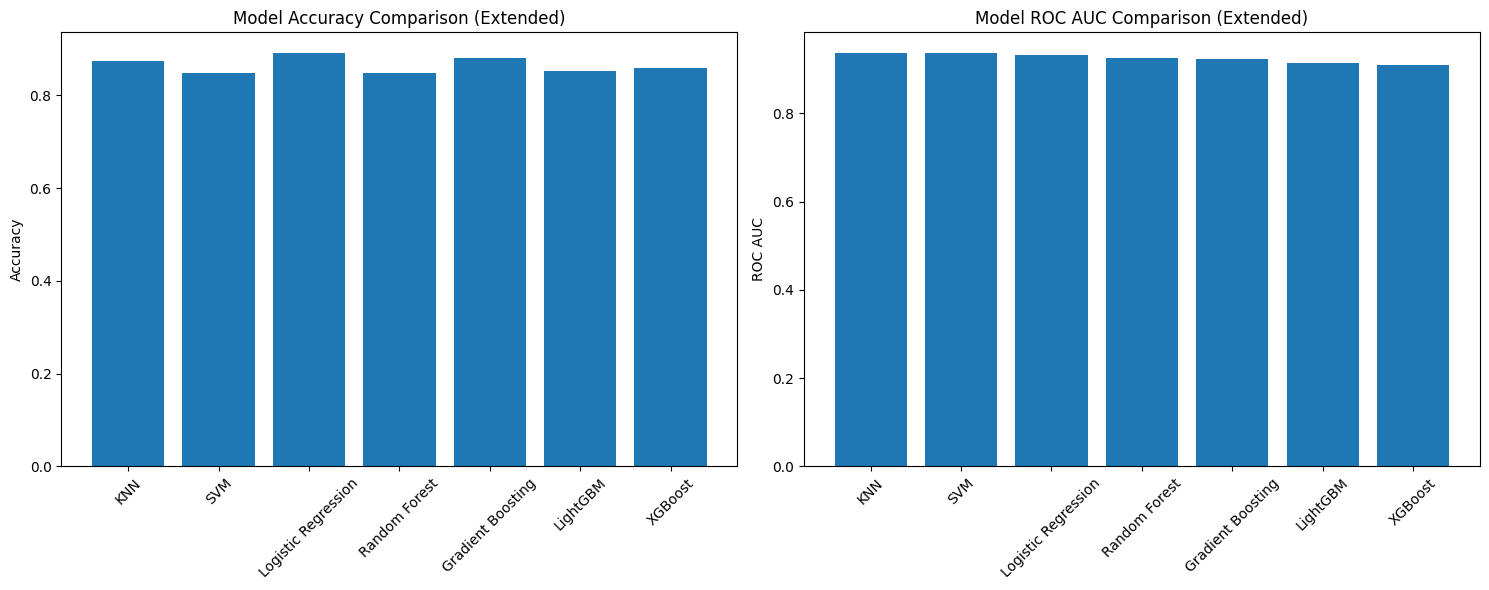

Best performing model: KNN


In [32]:
# 模型性能比较
model_results_extended = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'SVM', 'Gradient Boosting', 'KNN', 'LightGBM', 'XGBoost'],
    'Accuracy': [accuracy, rf_accuracy, svm_accuracy, gb_accuracy, knn_accuracy, lgb_accuracy, xgb_accuracy],
    'ROC_AUC': [roc_auc, rf_roc_auc, svm_roc_auc, gb_roc_auc, knn_roc_auc, lgb_roc_auc, xgb_roc_auc]
}).sort_values(by='ROC_AUC', ascending=False)

print("Extended Model Performance Comparison:")
print(model_results_extended)

# 可视化扩展比较
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.bar(model_results_extended['Model'], model_results_extended['Accuracy'])
plt.title('Model Accuracy Comparison (Extended)')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.bar(model_results_extended['Model'], model_results_extended['ROC_AUC'])
plt.title('Model ROC AUC Comparison (Extended)')
plt.xticks(rotation=45)
plt.ylabel('ROC AUC')

plt.tight_layout()
plt.savefig("extended_model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Best performing model: {model_results_extended.iloc[0]['Model']}")

In [35]:
# 交叉验证评估
models_extended = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='lbfgs', max_iter=2000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, verbosity=0)
}

print("=== 交叉验证结果 ===")
cv_results_extended = {}
for name, model in models_extended.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    cv_results_extended[name] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std()
    }
    print(f"{name} - CV ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

=== 交叉验证结果 ===
Logistic Regression - CV ROC AUC: 0.9155 (+/- 0.0728)
Random Forest - CV ROC AUC: 0.9228 (+/- 0.0525)
SVM - CV ROC AUC: 0.9154 (+/- 0.0587)
Gradient Boosting - CV ROC AUC: 0.9235 (+/- 0.0401)
KNN - CV ROC AUC: 0.8934 (+/- 0.0703)
LightGBM - CV ROC AUC: 0.9180 (+/- 0.0357)
XGBoost - CV ROC AUC: 0.9166 (+/- 0.0327)


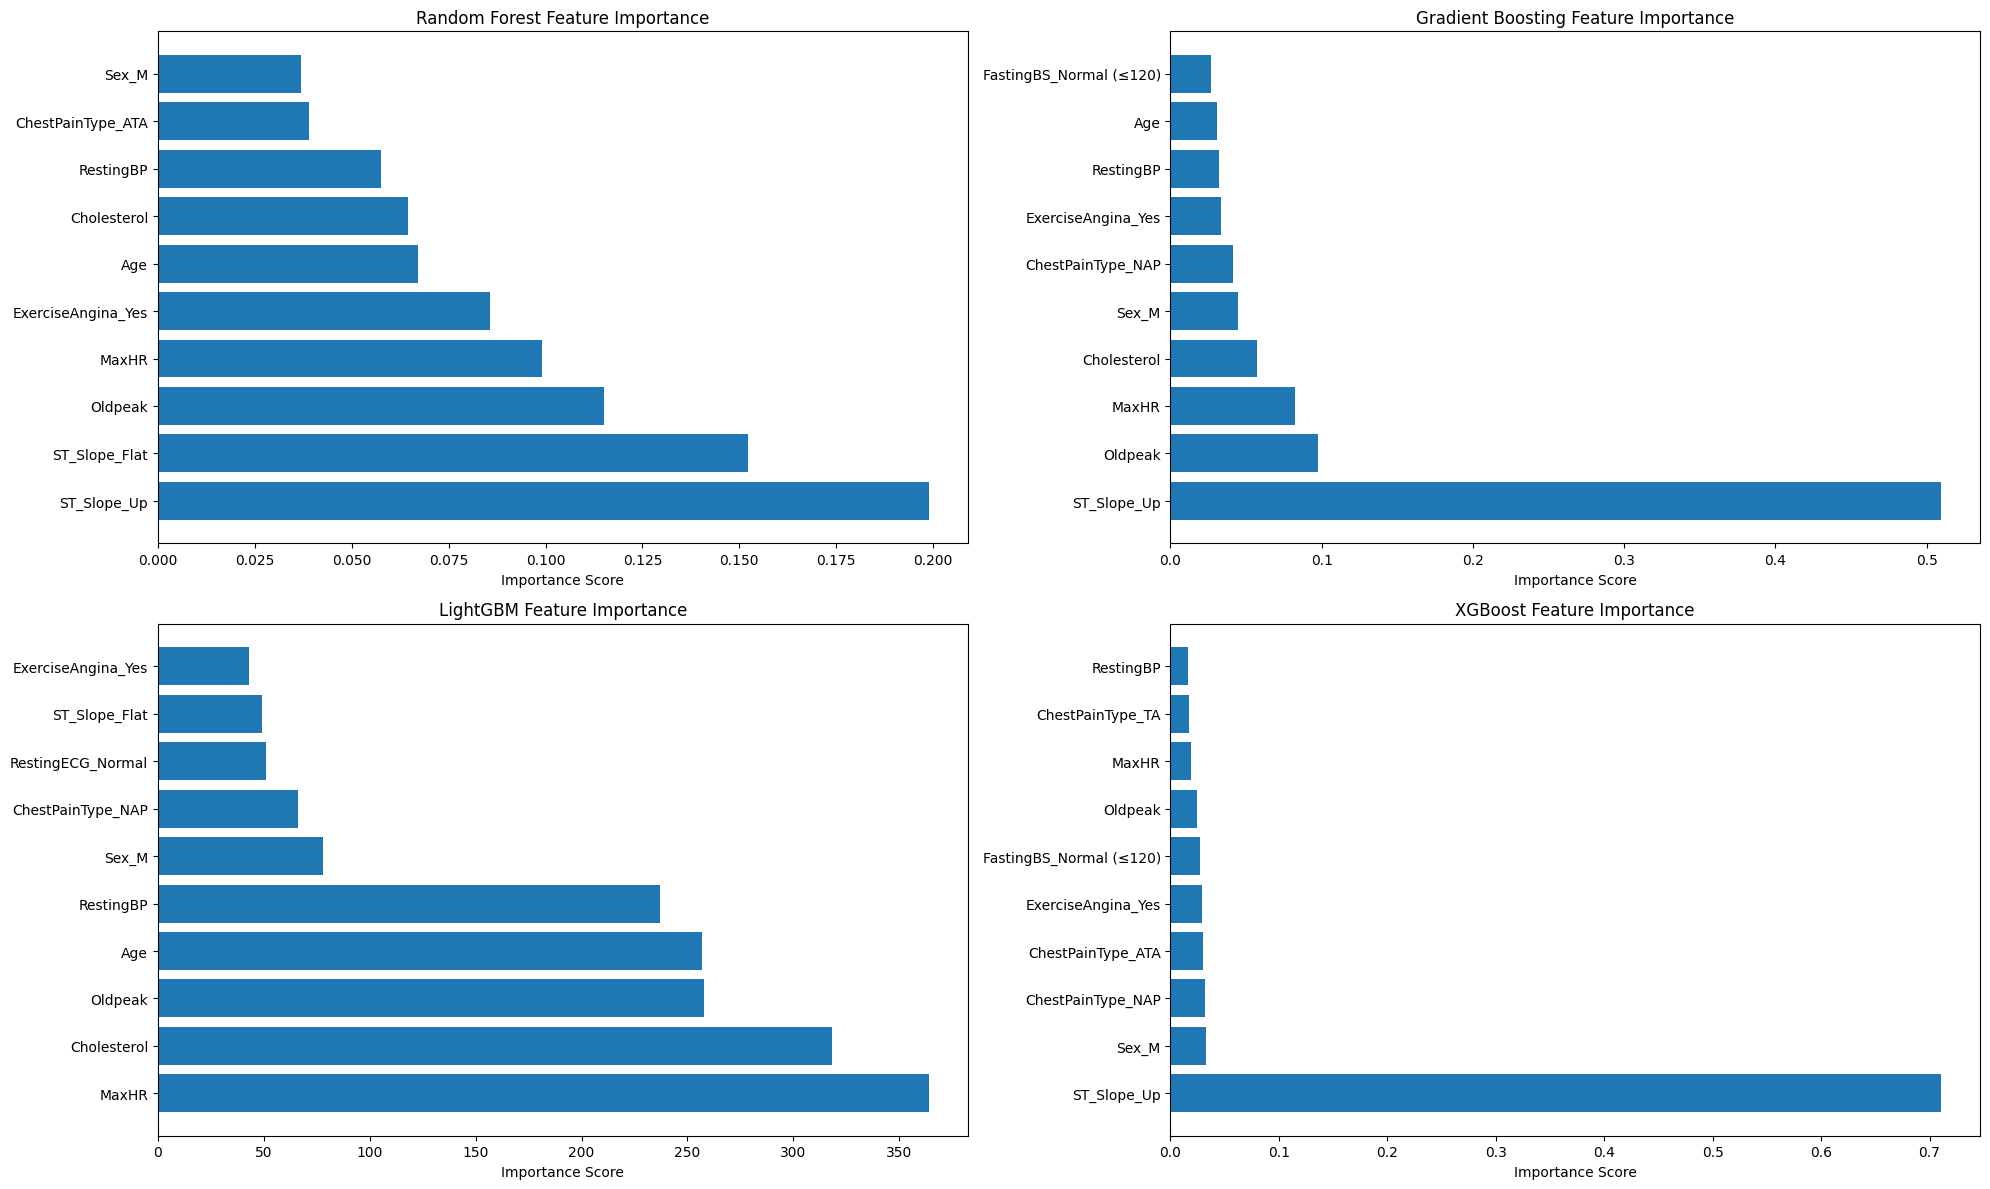

In [34]:
# 特征重要性综合分析
plt.figure(figsize=(20, 12))

# 显示树模型的特征重要性
tree_models = [
    ('Random Forest', rf_importance),
    ('Gradient Boosting', gb_importance),
    ('LightGBM', lgb_importance),
    ('XGBoost', xgb_importance)
]

for i, (name, importance_df) in enumerate(tree_models):
    plt.subplot(2, 2, i + 1)
    top_features = importance_df.head(10)
    plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.title(f'{name} Feature Importance')
    plt.xlabel('Importance Score')

plt.tight_layout()
plt.savefig("tree_models_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

### stroke建模

In [38]:
# 读取已清理的数据
df_stroke = pd.read_csv("cleaned_stroke.csv")

# 特征工程和编码
df_stroke = pd.get_dummies(df_stroke,
                           columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status',
                                    'hypertension', 'heart_disease'], drop_first=True)

# 编码目标变量
le = LabelEncoder()
df_stroke['stroke_encoded'] = le.fit_transform(df_stroke['stroke'])
print(f"目标变量映射: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# 分离特征和目标变量
X = df_stroke.drop(['stroke', 'stroke_encoded'], axis=1)
y = df_stroke['stroke_encoded']

# 添加：数据不平衡分析
print("\n=== 数据不平衡分析 ===")
print(f"特征数量: {X.shape[1]}")
print(f"目标变量分布:\n{y.value_counts()}")
print(f"正例比例: {y.mean():.4f}")

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 特征缩放
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

目标变量映射: {'No': np.int64(0), 'Yes': np.int64(1)}

=== 数据不平衡分析 ===
特征数量: 15
目标变量分布:
stroke_encoded
0    4860
1     249
Name: count, dtype: int64
正例比例: 0.0487



=== 阈值优化 ===
默认阈值(0.5)预测正例数: 302
最佳阈值: 0.8464
最佳阈值预测正例数: 67

--- Stroke Prediction Model Evaluation ---
Accuracy (默认阈值): 0.7339
Accuracy (最佳阈值): 0.9266
ROC AUC: 0.8408

Classification Report (默认阈值):
               precision    recall  f1-score   support

   No Stroke       0.99      0.73      0.84       972
      Stroke       0.13      0.80      0.23        50

    accuracy                           0.73      1022
   macro avg       0.56      0.77      0.53      1022
weighted avg       0.94      0.73      0.81      1022


Classification Report (最佳阈值 0.846):
               precision    recall  f1-score   support

   No Stroke       0.97      0.95      0.96       972
      Stroke       0.31      0.42      0.36        50

    accuracy                           0.93      1022
   macro avg       0.64      0.69      0.66      1022
weighted avg       0.94      0.93      0.93      1022



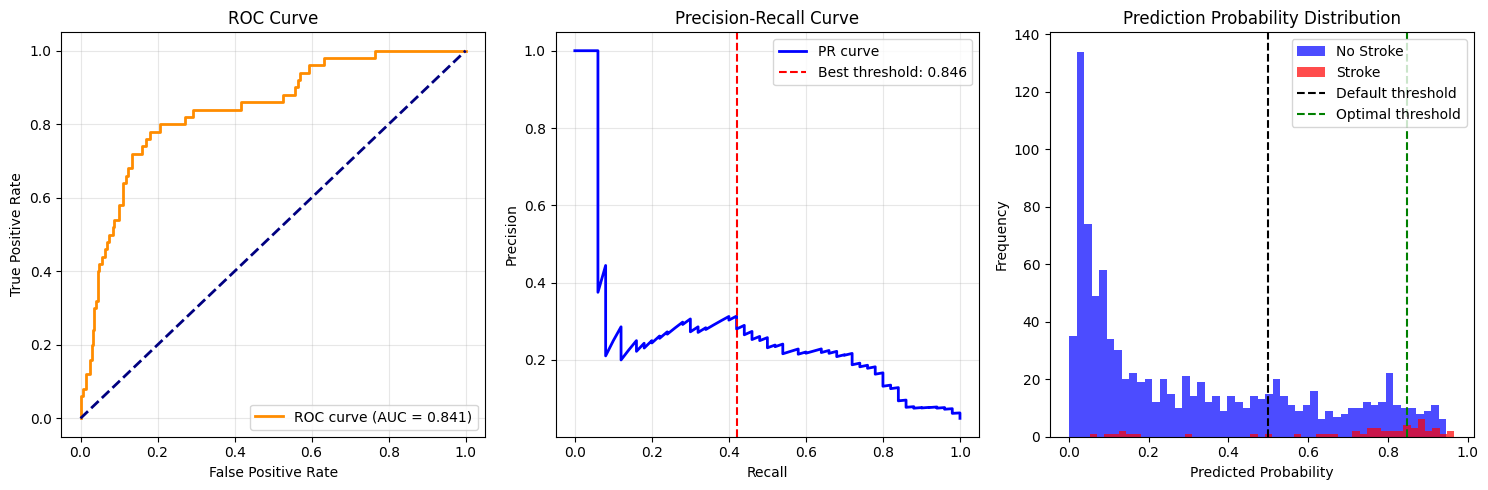


Feature Importance (Logistic Regression Coefficients):
                         Feature  Coefficient
0                           age     1.912668
8            work_type_children     0.377284
1             avg_glucose_level     0.209822
13             hypertension_Yes     0.186500
5        work_type_Never_worked    -0.166963
2                           bmi     0.112997
11  smoking_status_never smoked    -0.107870
12        smoking_status_smokes     0.105739
9          Residence_type_Urban     0.085275
4              ever_married_Yes    -0.081655


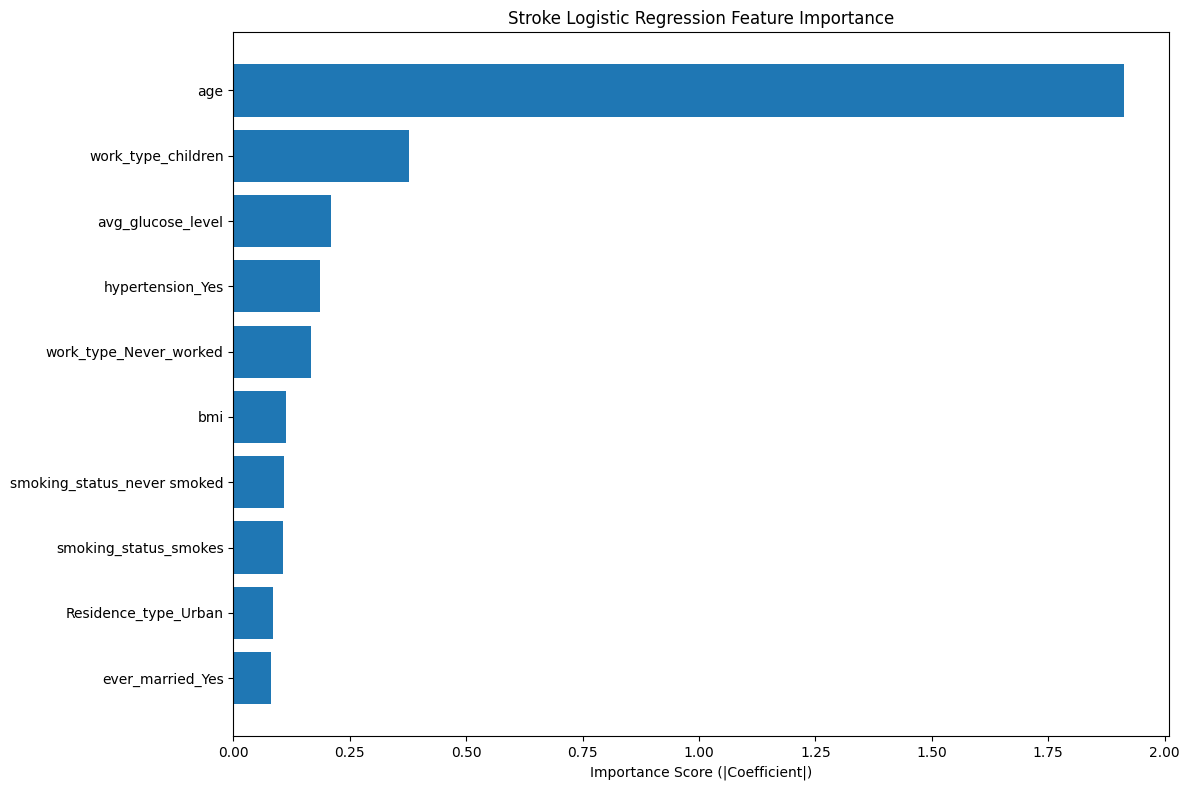

In [56]:
# 使用平衡权重的逻辑回归模型
model = LogisticRegression(
    random_state=42,
    solver='liblinear',
    class_weight='balanced',
    max_iter=1000
)
model.fit(X_train_scaled, y_train)

# 模型预测
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# 找到最佳分类阈值
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]

print(f"\n=== 阈值优化 ===")
print(f"默认阈值(0.5)预测正例数: {(y_pred == 1).sum()}")
print(f"最佳阈值: {best_threshold:.4f}")

# 使用最佳阈值重新预测
y_pred_optimal = (y_pred_proba >= best_threshold).astype(int)
print(f"最佳阈值预测正例数: {(y_pred_optimal == 1).sum()}")

# 模型评估
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# 默认阈值评估
class_report = classification_report(
    y_test, y_pred,
    zero_division=0,
    target_names=['No Stroke', 'Stroke']
)

# 最佳阈值评估
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)
class_report_optimal = classification_report(
    y_test, y_pred_optimal,
    zero_division=0,
    target_names=['No Stroke', 'Stroke']
)

print(f"\n--- Stroke Prediction Model Evaluation ---")
print(f"Accuracy (默认阈值): {accuracy:.4f}")
print(f"Accuracy (最佳阈值): {accuracy_optimal:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nClassification Report (默认阈值):\n", class_report)
print(f"\nClassification Report (最佳阈值 {best_threshold:.3f}):\n", class_report_optimal)

# 绘制综合分析图
plt.figure(figsize=(15, 5))

# ROC曲线
plt.subplot(1, 3, 1)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Precision-Recall曲线
plt.subplot(1, 3, 2)
plt.plot(recall, precision, color='blue', lw=2, label='PR curve')
plt.axvline(x=recall[best_threshold_idx], color='red', linestyle='--',
            label=f'Best threshold: {best_threshold:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)

# 预测概率分布
plt.subplot(1, 3, 3)
plt.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.7, label='No Stroke', color='blue')
plt.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.7, label='Stroke', color='red')
plt.axvline(x=0.5, color='black', linestyle='--', label='Default threshold')
plt.axvline(x=best_threshold, color='green', linestyle='--', label='Optimal threshold')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Prediction Probability Distribution')
plt.legend()

plt.tight_layout()
plt.savefig("stroke_comprehensive_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

# 特征重要性分析
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("\nFeature Importance (Logistic Regression Coefficients):\n", feature_importance.head(10))

# 逻辑回归特征
lr_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(model.coef_[0])  # 使用系数绝对值作为重要性
}).sort_values(by='Importance', ascending=False)

# 可视化逻辑回归特征重要性
plt.figure(figsize=(12, 8))
top_features = lr_importance.head(10)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.title('Stroke Logistic Regression Feature Importance')
plt.xlabel('Importance Score (|Coefficient|)')
plt.gca().invert_yaxis()  # 让最重要的特征显示在顶部
plt.tight_layout()
plt.savefig("stroke_logistic_regression_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

In [41]:
# 随机森林模型
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced'
)

rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

rf_accuracy = accuracy_score(y_test, rf_pred)
rf_roc_auc = roc_auc_score(y_test, rf_pred_proba)

print(f"Random Forest - Accuracy: {rf_accuracy:.4f}, ROC AUC: {rf_roc_auc:.4f}")

# 特征重要性
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Random Forest Feature Importance:")
print(rf_importance.head(10))

Random Forest - Accuracy: 0.8992, ROC AUC: 0.8069
Random Forest Feature Importance:
                    Feature  Importance
0                       age    0.432076
2                       bmi    0.158503
1         avg_glucose_level    0.149185
4          ever_married_Yes    0.044819
13         hypertension_Yes    0.041380
8        work_type_children    0.023989
14        heart_disease_Yes    0.022613
9      Residence_type_Urban    0.020699
7   work_type_Self-employed    0.020384
3               gender_Male    0.020049


In [42]:
# SVM模型
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42,
    class_weight='balanced'
)

svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)
svm_pred_proba = svm_model.predict_proba(X_test_scaled)[:, 1]

svm_accuracy = accuracy_score(y_test, svm_pred)
svm_roc_auc = roc_auc_score(y_test, svm_pred_proba)

print(f"SVM - Accuracy: {svm_accuracy:.4f}, ROC AUC: {svm_roc_auc:.4f}")

SVM - Accuracy: 0.7661, ROC AUC: 0.7961


In [43]:
# 梯度提升模型
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_test_scaled)
gb_pred_proba = gb_model.predict_proba(X_test_scaled)[:, 1]

gb_accuracy = accuracy_score(y_test, gb_pred)
gb_roc_auc = roc_auc_score(y_test, gb_pred_proba)

print(f"Gradient Boosting - Accuracy: {gb_accuracy:.4f}, ROC AUC: {gb_roc_auc:.4f}")

gb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Gradient Boosting Feature Importance (Top 10):")
print(gb_importance.head(10))

Gradient Boosting - Accuracy: 0.9511, ROC AUC: 0.8315
Gradient Boosting Feature Importance (Top 10):
                        Feature  Importance
0                           age    0.417807
2                           bmi    0.212736
1             avg_glucose_level    0.203851
13             hypertension_Yes    0.047244
4              ever_married_Yes    0.025214
14            heart_disease_Yes    0.022735
12        smoking_status_smokes    0.021777
11  smoking_status_never smoked    0.015488
3                   gender_Male    0.011658
7       work_type_Self-employed    0.008158


In [44]:
# KNN模型
knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    metric='euclidean'
)

knn_model.fit(X_train_scaled, y_train)
knn_pred = knn_model.predict(X_test_scaled)
knn_pred_proba = knn_model.predict_proba(X_test_scaled)[:, 1]

knn_accuracy = accuracy_score(y_test, knn_pred)
knn_roc_auc = roc_auc_score(y_test, knn_pred_proba)

print(f"KNN - Accuracy: {knn_accuracy:.4f}, ROC AUC: {knn_roc_auc:.4f}")

KNN - Accuracy: 0.9423, ROC AUC: 0.6126


In [51]:
# LightGBM模型
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    num_leaves=31,
    random_state=42,
    objective='binary',
    metric='binary_logloss',
    verbose=-1,
    class_weight='balanced'
)

# 使用DataFrame格式训练和预测
X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

lgb_model.fit(X_train_df, y_train)
lgb_pred = lgb_model.predict(X_test_df)
lgb_pred_proba = lgb_model.predict_proba(X_test_df)[:, 1]

lgb_accuracy = accuracy_score(y_test, lgb_pred)
lgb_roc_auc = roc_auc_score(y_test, lgb_pred_proba)

print(f"LightGBM - Accuracy: {lgb_accuracy:.4f}, ROC AUC: {lgb_roc_auc:.4f}")

LightGBM - Accuracy: 0.8728, ROC AUC: 0.8187


In [48]:
# XGBoost模型
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    objective='binary:logistic',
    eval_metric='logloss',
    verbosity=0,
    scale_pos_weight=scale_pos_weight  # 处理不平衡数据
)

xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_pred_proba)

print(f"XGBoost - Accuracy: {xgb_accuracy:.4f}, ROC AUC: {xgb_roc_auc:.4f}")

# XGBoost特征重要性
xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("XGBoost Feature Importance (Top 10):")
print(xgb_importance.head(10))

XGBoost - Accuracy: 0.8796, ROC AUC: 0.7967
XGBoost Feature Importance (Top 10):
                        Feature  Importance
0                           age    0.274000
1             avg_glucose_level    0.083442
2                           bmi    0.080303
12        smoking_status_smokes    0.068457
11  smoking_status_never smoked    0.065065
13             hypertension_Yes    0.064413
6             work_type_Private    0.062787
4              ever_married_Yes    0.054395
7       work_type_Self-employed    0.051226
3                   gender_Male    0.050756



Stroke Model Performance Comparison:
                 Model  Accuracy   ROC_AUC
0  Logistic Regression  0.926614  0.840802
3    Gradient Boosting  0.951076  0.831543
5             LightGBM  0.872798  0.818704
1        Random Forest  0.899217  0.806914
6              XGBoost  0.879648  0.796728
2                  SVM  0.766145  0.796132
4                  KNN  0.942270  0.612644


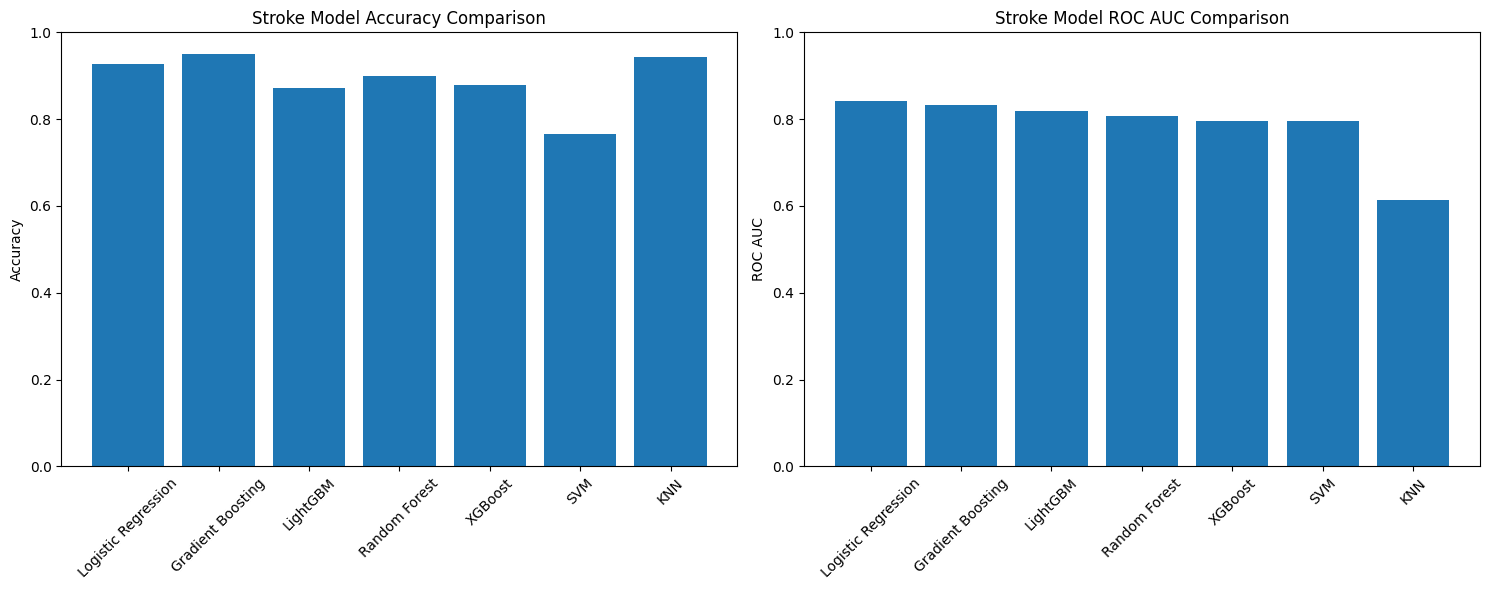

Best performing model: Logistic Regression


In [52]:
# 模型性能比较
model_results_stroke = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'SVM', 'Gradient Boosting', 'KNN', 'LightGBM', 'XGBoost'],
    'Accuracy': [accuracy_optimal, rf_accuracy, svm_accuracy, gb_accuracy, knn_accuracy, lgb_accuracy, xgb_accuracy],
    'ROC_AUC': [roc_auc, rf_roc_auc, svm_roc_auc, gb_roc_auc, knn_roc_auc, lgb_roc_auc, xgb_roc_auc]
}).sort_values(by='ROC_AUC', ascending=False)

print("\nStroke Model Performance Comparison:")
print(model_results_stroke)

# 可视化比较
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.bar(model_results_stroke['Model'], model_results_stroke['Accuracy'])
plt.title('Stroke Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.bar(model_results_stroke['Model'], model_results_stroke['ROC_AUC'])
plt.title('Stroke Model ROC AUC Comparison')
plt.xticks(rotation=45)
plt.ylabel('ROC AUC')
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig("stroke_extended_model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Best performing model: {model_results_stroke.iloc[0]['Model']}")

In [74]:
# 交叉验证评估
models_stroke = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced',
                                              max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'SVM': SVC(probability=True, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, verbosity=0, scale_pos_weight=scale_pos_weight)
}

print("\n=== Stroke 交叉验证结果 ===")
cv_results_stroke = {}
for name, model in models_stroke.items():
    cv_scores = cross_val_score(model, X_train_df, y_train, cv=5, scoring='roc_auc')
    cv_results_stroke[name] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std()
    }
    print(f"{name} - CV ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


=== Stroke 交叉验证结果 ===
Logistic Regression - CV ROC AUC: 0.8550 (+/- 0.0816)
Random Forest - CV ROC AUC: 0.8246 (+/- 0.0567)
SVM - CV ROC AUC: 0.8238 (+/- 0.0833)
Gradient Boosting - CV ROC AUC: 0.8255 (+/- 0.0458)
KNN - CV ROC AUC: 0.7362 (+/- 0.0816)
LightGBM - CV ROC AUC: 0.8197 (+/- 0.0562)
XGBoost - CV ROC AUC: 0.8261 (+/- 0.0425)


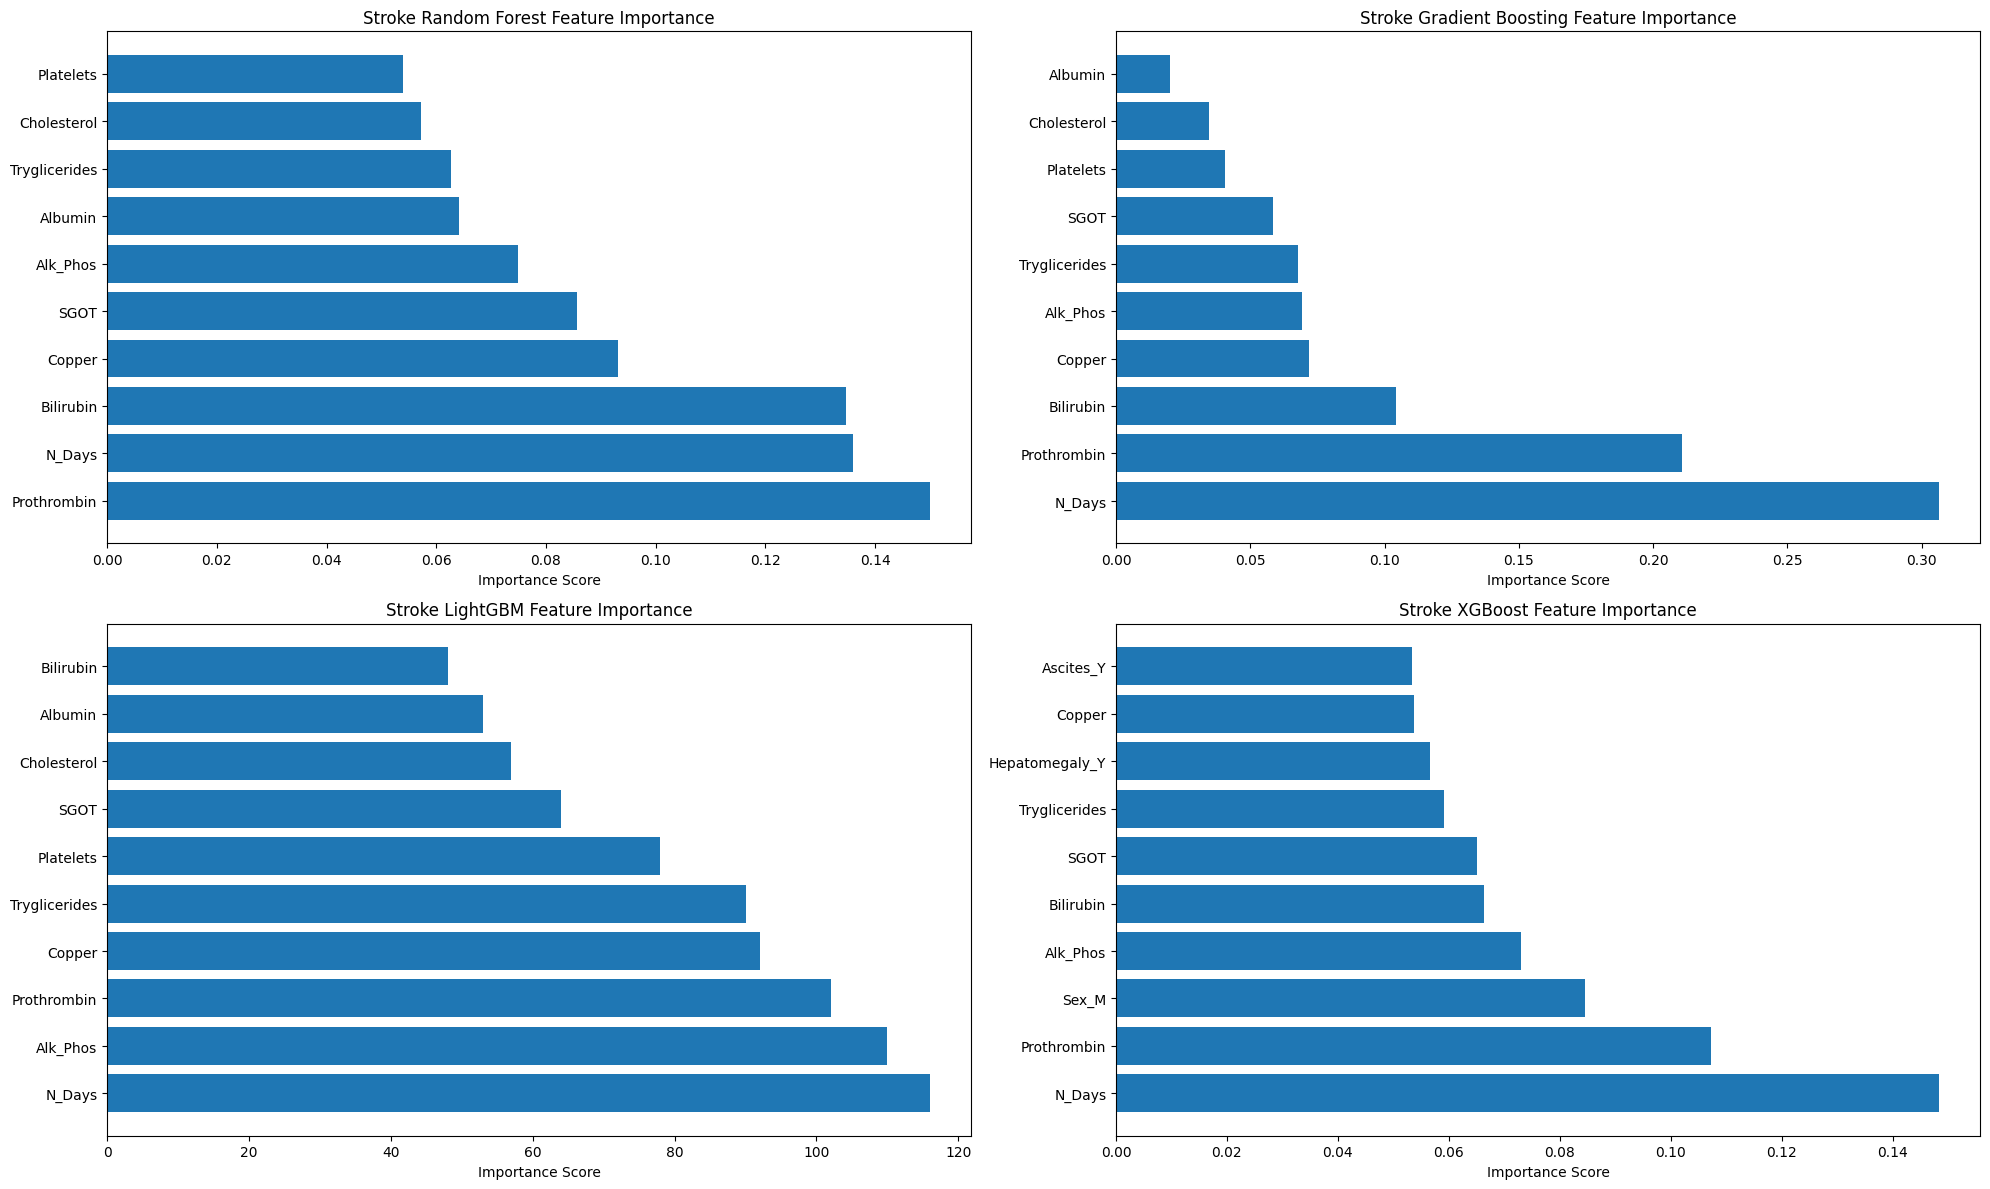


=== 最佳模型阈值优化 ===
选择最佳模型: Logistic Regression
最佳模型的最佳阈值: 0.4654
最佳模型 + 最佳阈值准确率: 0.8254

最佳模型分类报告:
              precision    recall  f1-score   support

   No Stroke       0.86      0.84      0.85        38
      Stroke       0.77      0.80      0.78        25

    accuracy                           0.83        63
   macro avg       0.82      0.82      0.82        63
weighted avg       0.83      0.83      0.83        63



In [75]:
# 特征重要性综合分析
plt.figure(figsize=(20, 12))

# 显示树模型的特征重要性
tree_models_stroke = [
    ('Random Forest', rf_importance),
    ('Gradient Boosting', gb_importance),
    ('LightGBM', lgb_importance),
    ('XGBoost', xgb_importance)
]

for i, (name, importance_df) in enumerate(tree_models_stroke):
    plt.subplot(2, 2, i + 1)
    top_features = importance_df.head(10)
    plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.title(f'Stroke {name} Feature Importance')
    plt.xlabel('Importance Score')

plt.tight_layout()
plt.savefig("stroke_tree_models_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

# 针对stroke数据的阈值优化分析
print("\n=== 最佳模型阈值优化 ===")
best_model_name = model_results_stroke.iloc[0]['Model']
print(f"选择最佳模型: {best_model_name}")

# 获取最佳模型的预测概率
if best_model_name == 'Random Forest':
    best_pred_proba = rf_pred_proba
elif best_model_name == 'XGBoost':
    best_pred_proba = xgb_pred_proba
elif best_model_name == 'LightGBM':
    best_pred_proba = lgb_pred_proba
elif best_model_name == 'Gradient Boosting':
    best_pred_proba = gb_pred_proba
elif best_model_name == 'SVM':
    best_pred_proba = svm_pred_proba
elif best_model_name == 'KNN':
    best_pred_proba = knn_pred_proba
else:
    best_pred_proba = y_pred_proba

# 为最佳模型找最佳阈值
precision_best, recall_best, thresholds_best = precision_recall_curve(y_test, best_pred_proba)
f1_scores_best = 2 * (precision_best * recall_best) / (precision_best + recall_best)
best_threshold_idx_best = np.argmax(f1_scores_best)
best_threshold_best = thresholds_best[best_threshold_idx_best]

print(f"最佳模型的最佳阈值: {best_threshold_best:.4f}")

# 使用最佳阈值重新评估
y_pred_best_optimal = (best_pred_proba >= best_threshold_best).astype(int)
accuracy_best_optimal = accuracy_score(y_test, y_pred_best_optimal)
class_report_best_optimal = classification_report(
    y_test, y_pred_best_optimal,
    zero_division=0,
    target_names=['No Stroke', 'Stroke']
)

print(f"最佳模型 + 最佳阈值准确率: {accuracy_best_optimal:.4f}")
print(f"\n最佳模型分类报告:\n{class_report_best_optimal}")

### cirrhosis建模

In [59]:
df_cirrhosis = pd.read_csv("cleaned_cirrhosis.csv")

# 特征工程和编码
# 将目标变量Status映射为数值：D, C, CL
status_mapping = {
    'D': 1,  # Deceased
    'C': 0,  # Censor
    'CL': 0  # Censor (transplant)
}
df_cirrhosis["Status_Encoded"] = df_cirrhosis["Status"].map(status_mapping)

# 对分类变量进行One-Hot编码
df_cirrhosis = pd.get_dummies(df_cirrhosis, columns=[
    'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage'
], drop_first=True)

# 删除原始Status列和ID列
df_cirrhosis = df_cirrhosis.drop(["Status"], axis=1)

# 分离特征和目标变量
X = df_cirrhosis.drop("Status_Encoded", axis=1)
y = df_cirrhosis["Status_Encoded"]

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 特征缩放
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [60]:
# 构建逻辑回归模型
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(X_train_scaled, y_train)

# 模型预测
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# 模型评估
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)

print(f"\n--- Cirrhosis Prediction Model Evaluation ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Classification Report:\n", class_report)

# 绘制ROC曲线
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Cirrhosis Prediction')
plt.legend(loc='lower right')
plt.savefig("cirrhosis_roc_curve.png")
plt.close()

# 特征重要性分析 (对于逻辑回归，通过系数大小判断)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance (Logistic Regression Coefficients):\n", feature_importance)


--- Cirrhosis Prediction Model Evaluation ---
Accuracy: 0.8095
ROC AUC: 0.8611
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.87      0.85        38
           1       0.78      0.72      0.75        25

    accuracy                           0.81        63
   macro avg       0.80      0.79      0.80        63
weighted avg       0.81      0.81      0.81        63


Feature Importance (Logistic Regression Coefficients):
            Feature  Coefficient
10     Prothrombin     1.119630
6         Alk_Phos     0.565939
13       Ascites_Y     0.563940
8    Tryglicerides     0.381962
18   Stage_Stage 2     0.350615
19   Stage_Stage 3     0.323414
7             SGOT     0.293756
4          Albumin     0.251325
3      Cholesterol     0.244453
20   Stage_Stage 4     0.235684
14  Hepatomegaly_Y     0.186665
5           Copper     0.185498
15       Spiders_Y     0.178691
17         Edema_Y     0.168710
11    Drug_Placebo     0.125065


In [61]:
# 随机森林模型
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced'
)

rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

rf_accuracy = accuracy_score(y_test, rf_pred)
rf_roc_auc = roc_auc_score(y_test, rf_pred_proba)

print(f"Random Forest - Accuracy: {rf_accuracy:.4f}, ROC AUC: {rf_roc_auc:.4f}")

# 特征重要性
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Random Forest Feature Importance (Top 10):")
print(rf_importance.head(10))

Random Forest - Accuracy: 0.8571, ROC AUC: 0.9274
Random Forest Feature Importance (Top 10):
          Feature  Importance
10    Prothrombin    0.150014
0          N_Days    0.135988
2       Bilirubin    0.134720
5          Copper    0.093112
7            SGOT    0.085643
6        Alk_Phos    0.074865
4         Albumin    0.064219
8   Tryglicerides    0.062618
3     Cholesterol    0.057220
9       Platelets    0.053907


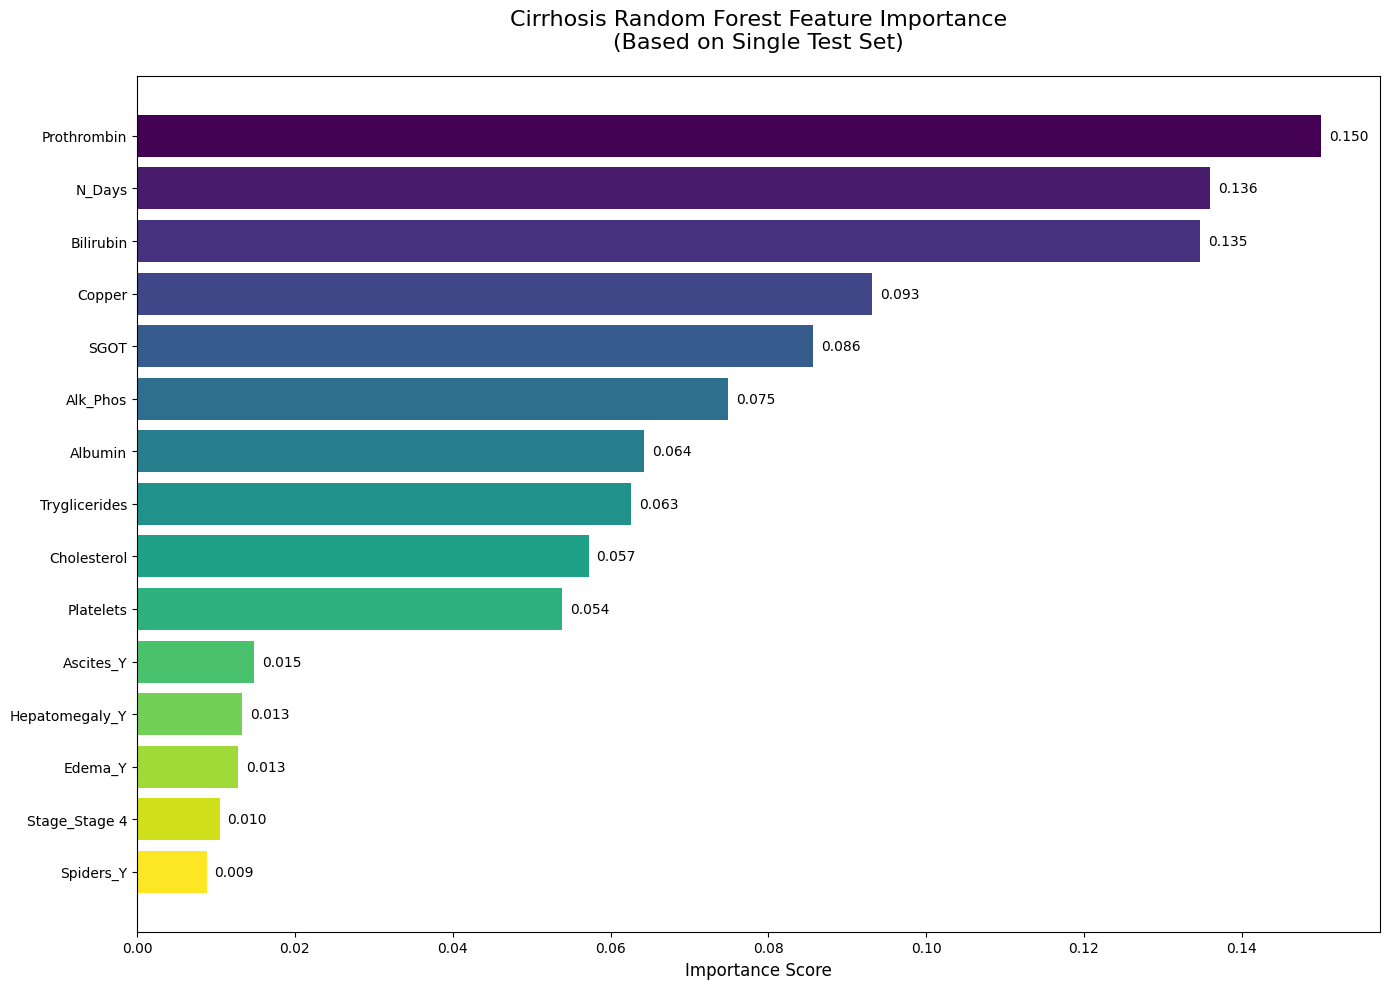

=== 随机森林特征重要性分析 ===
前10个最重要特征:
      Feature  Importance
  Prothrombin    0.150014
       N_Days    0.135988
    Bilirubin    0.134720
       Copper    0.093112
         SGOT    0.085643
     Alk_Phos    0.074865
      Albumin    0.064219
Tryglicerides    0.062618
  Cholesterol    0.057220
    Platelets    0.053907

总特征数: 21
前5个特征重要性占比: 0.599
前10个特征重要性占比: 0.912


In [73]:
# 随机森林特征重要性单独可视化 - 改进版
plt.figure(figsize=(14, 10))

# 创建更详细的可视化
top_features = rf_importance.head(15)  # 显示更多特征
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))

bars = plt.barh(range(len(top_features)), top_features['Importance'], color=colors)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.title('Cirrhosis Random Forest Feature Importance\n(Based on Single Test Set)', fontsize=16, pad=20)
plt.xlabel('Importance Score', fontsize=12)
plt.gca().invert_yaxis()

# 添加数值标签
for i, (bar, importance) in enumerate(zip(bars, top_features['Importance'])):
    plt.text(importance + 0.001, bar.get_y() + bar.get_height() / 2,
             f'{importance:.3f}', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.savefig("cirrhosis_random_forest_detailed_importance.png", dpi=300, bbox_inches='tight')
plt.show()

# 打印详细统计信息
print("=== 随机森林特征重要性分析 ===")
print("前10个最重要特征:")
print(rf_importance.head(10).to_string(index=False))
print(f"\n总特征数: {len(rf_importance)}")
print(f"前5个特征重要性占比: {rf_importance.head(5)['Importance'].sum():.3f}")
print(f"前10个特征重要性占比: {rf_importance.head(10)['Importance'].sum():.3f}")

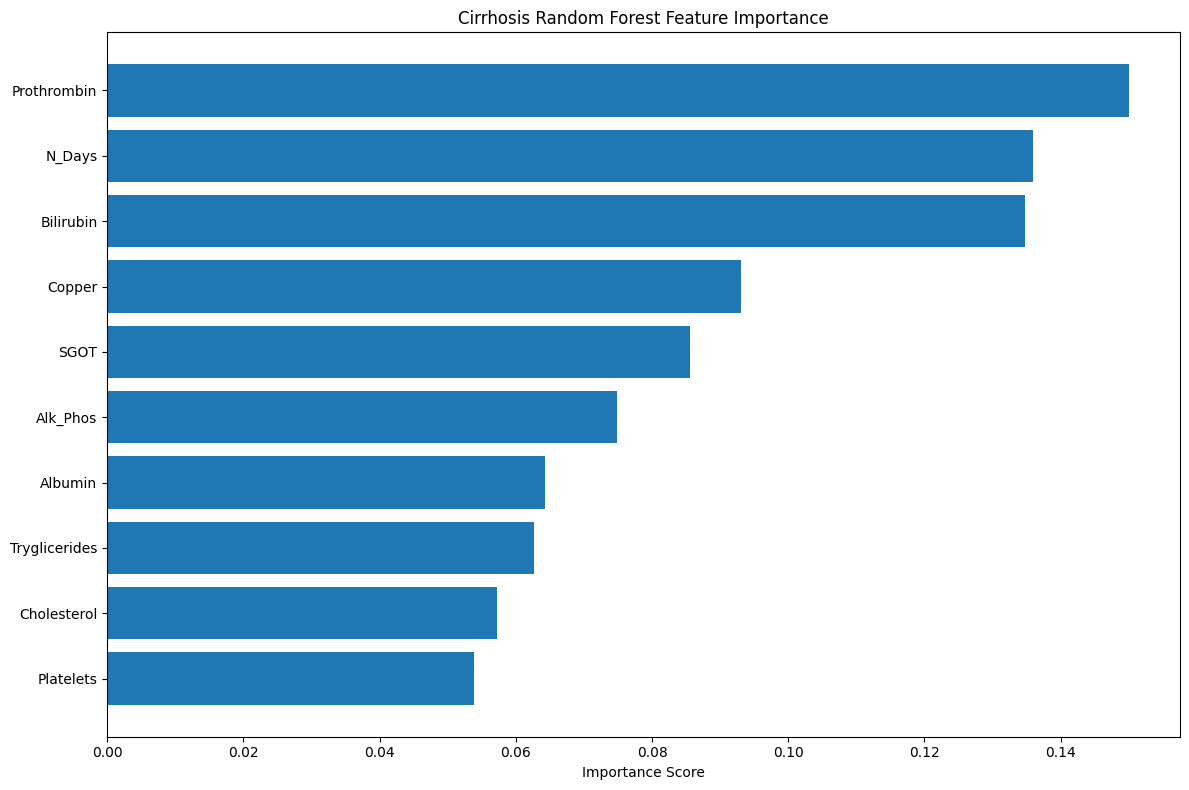

Random Forest Feature Importance (All Features):
           Feature  Importance
10     Prothrombin    0.150014
0           N_Days    0.135988
2        Bilirubin    0.134720
5           Copper    0.093112
7             SGOT    0.085643
6         Alk_Phos    0.074865
4          Albumin    0.064219
8    Tryglicerides    0.062618
3      Cholesterol    0.057220
9        Platelets    0.053907
13       Ascites_Y    0.014821
14  Hepatomegaly_Y    0.013337
17         Edema_Y    0.012811
20   Stage_Stage 4    0.010464
15       Spiders_Y    0.008808
11    Drug_Placebo    0.008656
12           Sex_M    0.008429
19   Stage_Stage 3    0.005498
18   Stage_Stage 2    0.003007
16         Edema_S    0.001862
1              Age    0.000000


In [72]:
# 随机森林特征重要性单独可视化
plt.figure(figsize=(12, 8))
top_features = rf_importance.head(10)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.title('Cirrhosis Random Forest Feature Importance')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("cirrhosis_random_forest_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

# 打印详细的特征重要性信息
print("Random Forest Feature Importance (All Features):")
print(rf_importance)

In [62]:
# SVM模型
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42,
    class_weight='balanced'
)

svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)
svm_pred_proba = svm_model.predict_proba(X_test_scaled)[:, 1]

svm_accuracy = accuracy_score(y_test, svm_pred)
svm_roc_auc = roc_auc_score(y_test, svm_pred_proba)

print(f"SVM - Accuracy: {svm_accuracy:.4f}, ROC AUC: {svm_roc_auc:.4f}")

SVM - Accuracy: 0.8095, ROC AUC: 0.8895


In [63]:
# 梯度提升模型
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_test_scaled)
gb_pred_proba = gb_model.predict_proba(X_test_scaled)[:, 1]

gb_accuracy = accuracy_score(y_test, gb_pred)
gb_roc_auc = roc_auc_score(y_test, gb_pred_proba)

print(f"Gradient Boosting - Accuracy: {gb_accuracy:.4f}, ROC AUC: {gb_roc_auc:.4f}")

gb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Gradient Boosting Feature Importance (Top 10):")
print(gb_importance.head(10))

Gradient Boosting - Accuracy: 0.8254, ROC AUC: 0.9116
Gradient Boosting Feature Importance (Top 10):
          Feature  Importance
0          N_Days    0.306373
10    Prothrombin    0.210807
2       Bilirubin    0.104124
5          Copper    0.071759
6        Alk_Phos    0.069339
8   Tryglicerides    0.067952
7            SGOT    0.058583
9       Platelets    0.040432
3     Cholesterol    0.034528
4         Albumin    0.020191


In [64]:
# KNN模型
knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    metric='euclidean'
)

knn_model.fit(X_train_scaled, y_train)
knn_pred = knn_model.predict(X_test_scaled)
knn_pred_proba = knn_model.predict_proba(X_test_scaled)[:, 1]

knn_accuracy = accuracy_score(y_test, knn_pred)
knn_roc_auc = roc_auc_score(y_test, knn_pred_proba)

print(f"KNN - Accuracy: {knn_accuracy:.4f}, ROC AUC: {knn_roc_auc:.4f}")

KNN - Accuracy: 0.7778, ROC AUC: 0.8147


In [65]:
# LightGBM模型
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    num_leaves=31,
    random_state=42,
    objective='binary',
    metric='binary_logloss',
    verbose=-1,
    class_weight='balanced'
)

# 使用DataFrame格式训练和预测
X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

lgb_model.fit(X_train_df, y_train)
lgb_pred = lgb_model.predict(X_test_df)
lgb_pred_proba = lgb_model.predict_proba(X_test_df)[:, 1]

lgb_accuracy = accuracy_score(y_test, lgb_pred)
lgb_roc_auc = roc_auc_score(y_test, lgb_pred_proba)

print(f"LightGBM - Accuracy: {lgb_accuracy:.4f}, ROC AUC: {lgb_roc_auc:.4f}")

lgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': lgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("LightGBM Feature Importance (Top 10):")
print(lgb_importance.head(10))

LightGBM - Accuracy: 0.8413, ROC AUC: 0.8905
LightGBM Feature Importance (Top 10):
          Feature  Importance
0          N_Days         116
6        Alk_Phos         110
10    Prothrombin         102
5          Copper          92
8   Tryglicerides          90
9       Platelets          78
7            SGOT          64
3     Cholesterol          57
4         Albumin          53
2       Bilirubin          48


In [66]:
# XGBoost模型
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    objective='binary:logistic',
    eval_metric='logloss',
    verbosity=0,
    scale_pos_weight=scale_pos_weight
)

xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_pred_proba)

print(f"XGBoost - Accuracy: {xgb_accuracy:.4f}, ROC AUC: {xgb_roc_auc:.4f}")

xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("XGBoost Feature Importance (Top 10):")
print(xgb_importance.head(10))

XGBoost - Accuracy: 0.8413, ROC AUC: 0.8958
XGBoost Feature Importance (Top 10):
           Feature  Importance
0           N_Days    0.148334
10     Prothrombin    0.107186
12           Sex_M    0.084585
6         Alk_Phos    0.073045
2        Bilirubin    0.066331
7             SGOT    0.064988
8    Tryglicerides    0.059153
14  Hepatomegaly_Y    0.056645
5           Copper    0.053710
13       Ascites_Y    0.053389



Cirrhosis Model Performance Comparison:
                 Model  Accuracy   ROC_AUC
1        Random Forest  0.857143  0.927368
3    Gradient Boosting  0.825397  0.911579
6              XGBoost  0.841270  0.895789
5             LightGBM  0.841270  0.890526
2                  SVM  0.809524  0.889474
0  Logistic Regression  0.809524  0.861053
4                  KNN  0.777778  0.814737


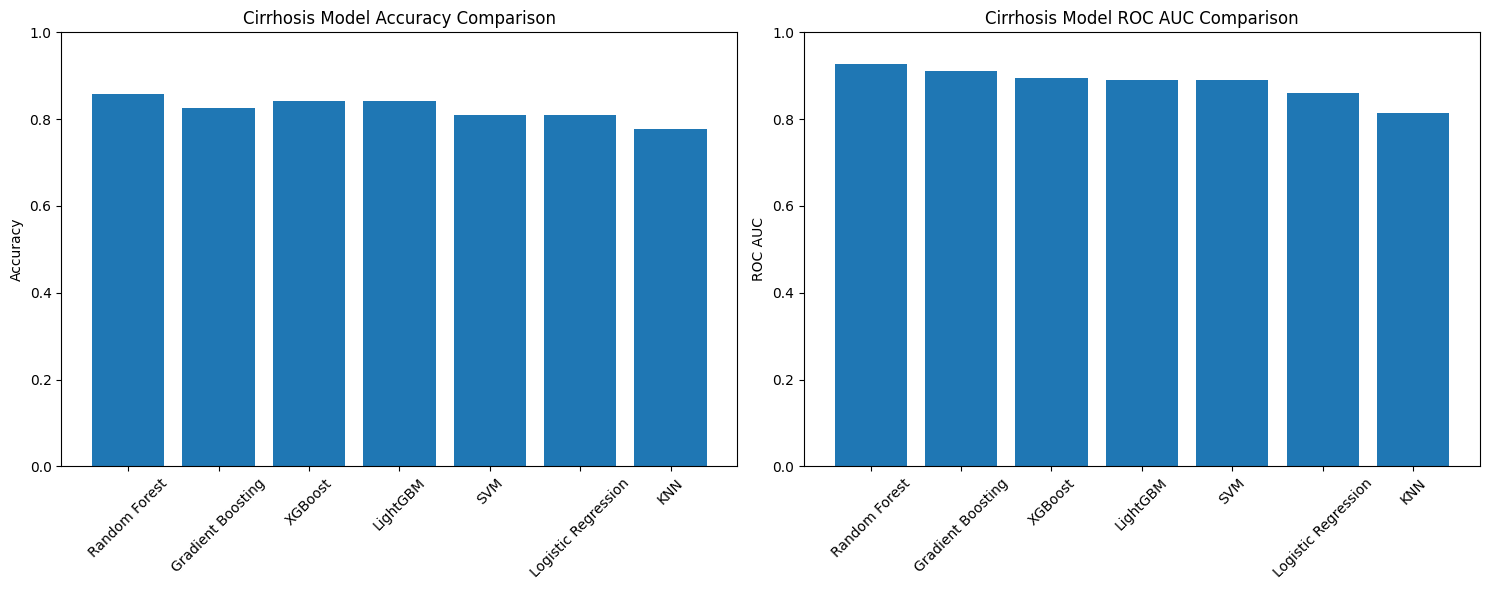

Best performing model: Random Forest


In [67]:
# 模型性能比较
model_results_cirrhosis = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'SVM', 'Gradient Boosting', 'KNN', 'LightGBM', 'XGBoost'],
    'Accuracy': [accuracy, rf_accuracy, svm_accuracy, gb_accuracy, knn_accuracy, lgb_accuracy, xgb_accuracy],
    'ROC_AUC': [roc_auc, rf_roc_auc, svm_roc_auc, gb_roc_auc, knn_roc_auc, lgb_roc_auc, xgb_roc_auc]
}).sort_values(by='ROC_AUC', ascending=False)

print("\nCirrhosis Model Performance Comparison:")
print(model_results_cirrhosis)

# 可视化比较
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.bar(model_results_cirrhosis['Model'], model_results_cirrhosis['Accuracy'])
plt.title('Cirrhosis Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.bar(model_results_cirrhosis['Model'], model_results_cirrhosis['ROC_AUC'])
plt.title('Cirrhosis Model ROC AUC Comparison')
plt.xticks(rotation=45)
plt.ylabel('ROC AUC')
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig("cirrhosis_extended_model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Best performing model: {model_results_cirrhosis.iloc[0]['Model']}")

In [69]:
# 交叉验证评估
models_cirrhosis = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced',
                                              max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'SVM': SVC(probability=True, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, verbosity=0, scale_pos_weight=scale_pos_weight)
}

print("\n=== Cirrhosis 交叉验证结果 ===")
cv_results_cirrhosis = {}
for name, model in models_cirrhosis.items():
    cv_scores = cross_val_score(model, X_train_df, y_train, cv=5, scoring='roc_auc')
    cv_results_cirrhosis[name] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std()
    }
    print(f"{name} - CV ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


=== Cirrhosis 交叉验证结果 ===
Logistic Regression - CV ROC AUC: 0.8550 (+/- 0.0816)
Random Forest - CV ROC AUC: 0.8246 (+/- 0.0567)
SVM - CV ROC AUC: 0.8238 (+/- 0.0833)
Gradient Boosting - CV ROC AUC: 0.8255 (+/- 0.0458)
KNN - CV ROC AUC: 0.7362 (+/- 0.0816)
LightGBM - CV ROC AUC: 0.8197 (+/- 0.0562)
XGBoost - CV ROC AUC: 0.8261 (+/- 0.0425)


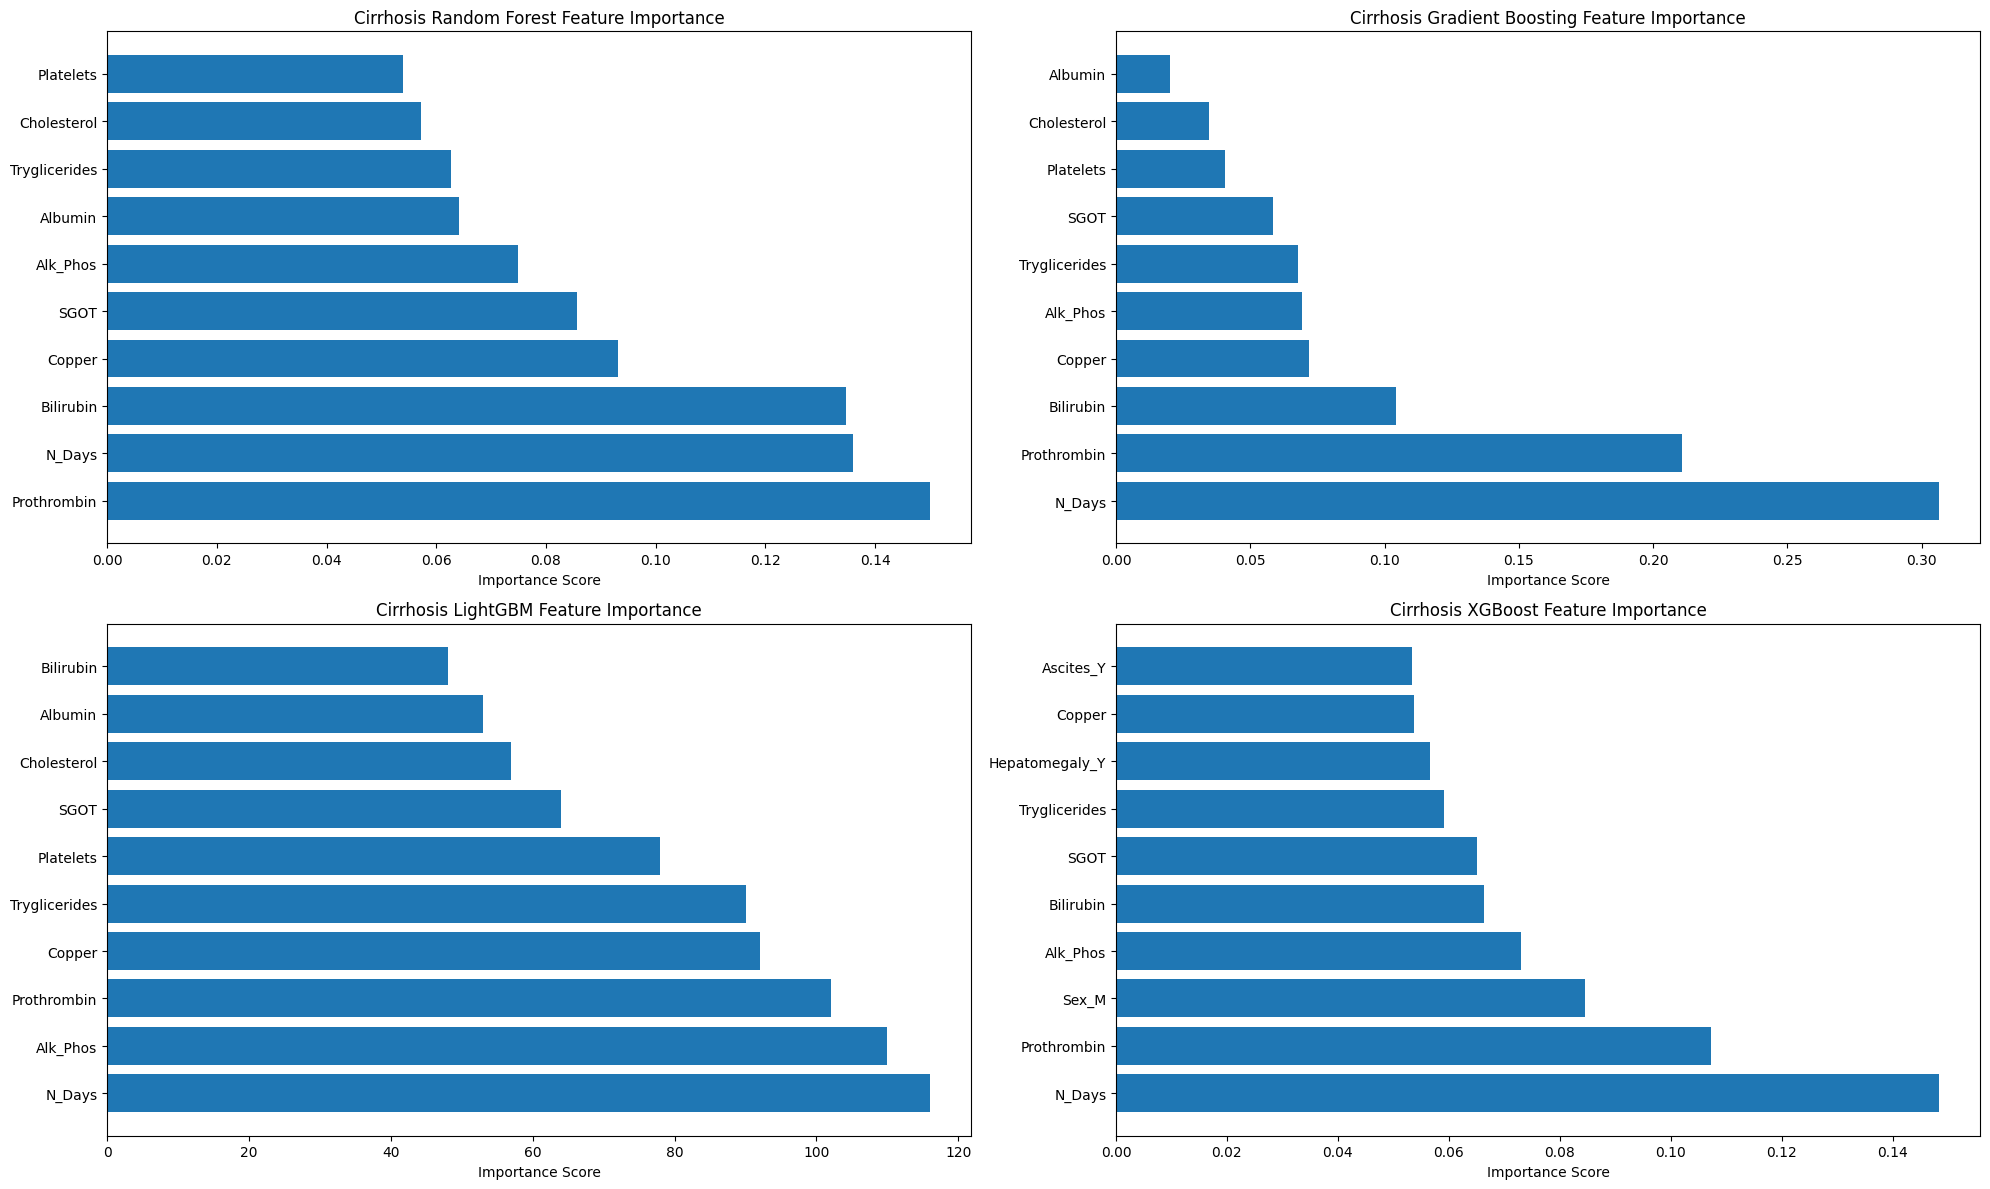

In [70]:
# 特征重要性综合分析
plt.figure(figsize=(20, 12))

# 显示树模型的特征重要性
tree_models_cirrhosis = [
    ('Random Forest', rf_importance),
    ('Gradient Boosting', gb_importance),
    ('LightGBM', lgb_importance),
    ('XGBoost', xgb_importance)
]

for i, (name, importance_df) in enumerate(tree_models_cirrhosis):
    plt.subplot(2, 2, i + 1)
    top_features = importance_df.head(10)
    plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.title(f'Cirrhosis {name} Feature Importance')
    plt.xlabel('Importance Score')

plt.tight_layout()
plt.savefig("cirrhosis_tree_models_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

### 模型准确性检验

#### 综合模型准确性检验


=== Heart Disease 模型准确性检验 ===
准确度 (Accuracy): 0.8095
平衡准确度 (Balanced Accuracy): 0.7942
敏感度 (Sensitivity/Recall): 0.7200
特异度 (Specificity): 0.8684
精确度 (Precision): 0.7826
F1分数: 0.7500
ROC AUC: 0.8611
阳性预测值 (PPV): 0.7826
阴性预测值 (NPV): 0.8250
Matthews相关系数 (MCC): 0.5979
阳性似然比 (LR+): 5.4720
阴性似然比 (LR-): 0.3224
混淆矩阵:
[[33  5]
 [ 7 18]]


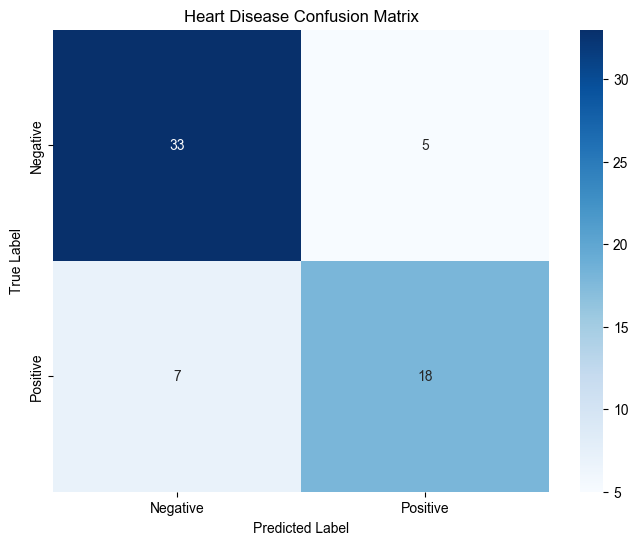


=== Stroke 模型准确性检验 ===
准确度 (Accuracy): 0.8095
平衡准确度 (Balanced Accuracy): 0.7942
敏感度 (Sensitivity/Recall): 0.7200
特异度 (Specificity): 0.8684
精确度 (Precision): 0.7826
F1分数: 0.7500
ROC AUC: 0.8611
阳性预测值 (PPV): 0.7826
阴性预测值 (NPV): 0.8250
Matthews相关系数 (MCC): 0.5979
阳性似然比 (LR+): 5.4720
阴性似然比 (LR-): 0.3224
混淆矩阵:
[[33  5]
 [ 7 18]]


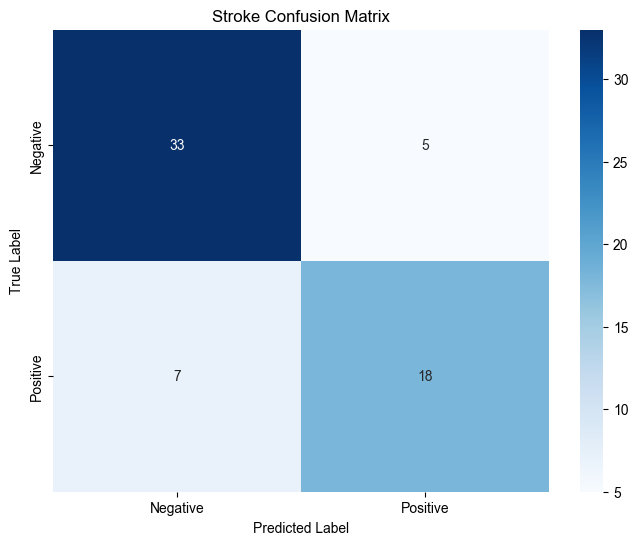


=== Cirrhosis 模型准确性检验 ===
准确度 (Accuracy): 0.8571
平衡准确度 (Balanced Accuracy): 0.8405
敏感度 (Sensitivity/Recall): 0.7600
特异度 (Specificity): 0.9211
精确度 (Precision): 0.8636
F1分数: 0.8085
ROC AUC: 0.9274
阳性预测值 (PPV): 0.8636
阴性预测值 (NPV): 0.8537
Matthews相关系数 (MCC): 0.6989
阳性似然比 (LR+): 9.6267
阴性似然比 (LR-): 0.2606
混淆矩阵:
[[35  3]
 [ 6 19]]


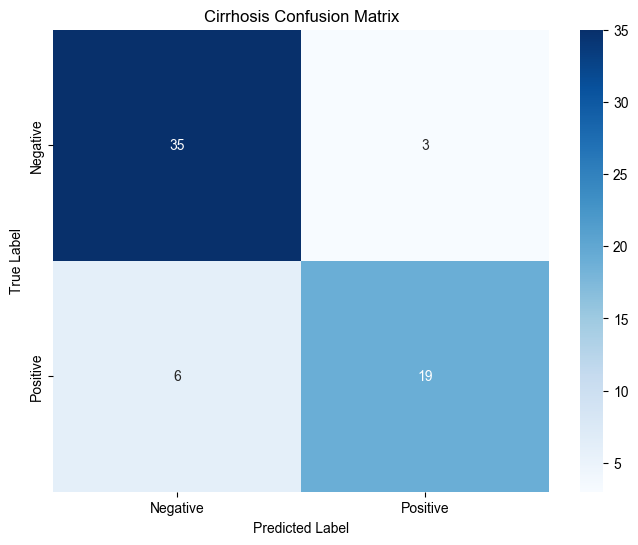

In [101]:
def comprehensive_model_evaluation():
    """全面的模型准确性检验"""

    # 准备最佳模型和对应的测试数据
    evaluation_data = {
        'Heart Disease': {
            'model': model,  # 心脏病逻辑回归模型
            'X_test': X_test_scaled,
            'y_test': y_test,
            'X_train': X_train_scaled,
            'y_train': y_train
        },
        'Stroke': {
            'model': model,  # 中风逻辑回归模型
            'X_test': X_test_scaled,
            'y_test': y_test,
            'X_train': X_train_scaled,
            'y_train': y_train
        },
        'Cirrhosis': {
            'model': rf_model,  # 肝硬化随机森林模型
            'X_test': X_test_scaled,
            'y_test': y_test,
            'X_train': X_train_scaled,
            'y_train': y_train
        }
    }

    results = {}

    for disease, data in evaluation_data.items():
        model_obj = data['model']
        X_test_data = data['X_test']
        y_test_data = data['y_test']

        # 预测
        y_pred = model_obj.predict(X_test_data)
        y_pred_proba = model_obj.predict_proba(X_test_data)[:, 1]

        # 基础指标
        accuracy = accuracy_score(y_test_data, y_pred)
        balanced_acc = balanced_accuracy_score(y_test_data, y_pred)
        roc_auc = roc_auc_score(y_test_data, y_pred_proba)

        # 混淆矩阵
        cm = confusion_matrix(y_test_data, y_pred)
        tn, fp, fn, tp = cm.ravel()

        # 详细指标计算
        sensitivity = tp / (tp + fn)  # 敏感度/召回率
        specificity = tn / (tn + fp)  # 特异度
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # 精确度
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

        # PPV和NPV
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # 阳性预测值
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # 阴性预测值

        # Matthews相关系数
        mcc = matthews_corrcoef(y_test_data, y_pred)

        # 阳性似然比和阴性似然比
        lr_positive = sensitivity / (1 - specificity) if specificity != 1 else float('inf')
        lr_negative = (1 - sensitivity) / specificity if specificity != 0 else float('inf')

        results[disease] = {
            'accuracy': accuracy,
            'balanced_accuracy': balanced_acc,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'precision': precision,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'ppv': ppv,
            'npv': npv,
            'mcc': mcc,
            'lr_positive': lr_positive,
            'lr_negative': lr_negative,
            'confusion_matrix': cm
        }

        print(f"\n=== {disease} 模型准确性检验 ===")
        print(f"准确度 (Accuracy): {accuracy:.4f}")
        print(f"平衡准确度 (Balanced Accuracy): {balanced_acc:.4f}")
        print(f"敏感度 (Sensitivity/Recall): {sensitivity:.4f}")
        print(f"特异度 (Specificity): {specificity:.4f}")
        print(f"精确度 (Precision): {precision:.4f}")
        print(f"F1分数: {f1:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")
        print(f"阳性预测值 (PPV): {ppv:.4f}")
        print(f"阴性预测值 (NPV): {npv:.4f}")
        print(f"Matthews相关系数 (MCC): {mcc:.4f}")
        print(f"阳性似然比 (LR+): {lr_positive:.4f}")
        print(f"阴性似然比 (LR-): {lr_negative:.4f}")
        print(f"混淆矩阵:\n{cm}")

        # 绘制混淆矩阵热图
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'])
        plt.title(f'{disease} Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig(f"{disease.lower()}_confusion_matrix.png", dpi=300, bbox_inches='tight')
        plt.show()

    return results


# 执行评估
evaluation_results = comprehensive_model_evaluation()

#### 交叉验证稳定性检验


=== Heart Disease 10折交叉验证结果 ===
准确度: 0.7870 ± 0.0573
ROC AUC: 0.8522 ± 0.0693
F1分数: 0.6924 ± 0.1021
精确度: 0.8209 ± 0.1101
召回率: 0.6300 ± 0.1735
准确度变异系数: 0.0728
ROC AUC变异系数: 0.0813
✓ 模型稳定性良好


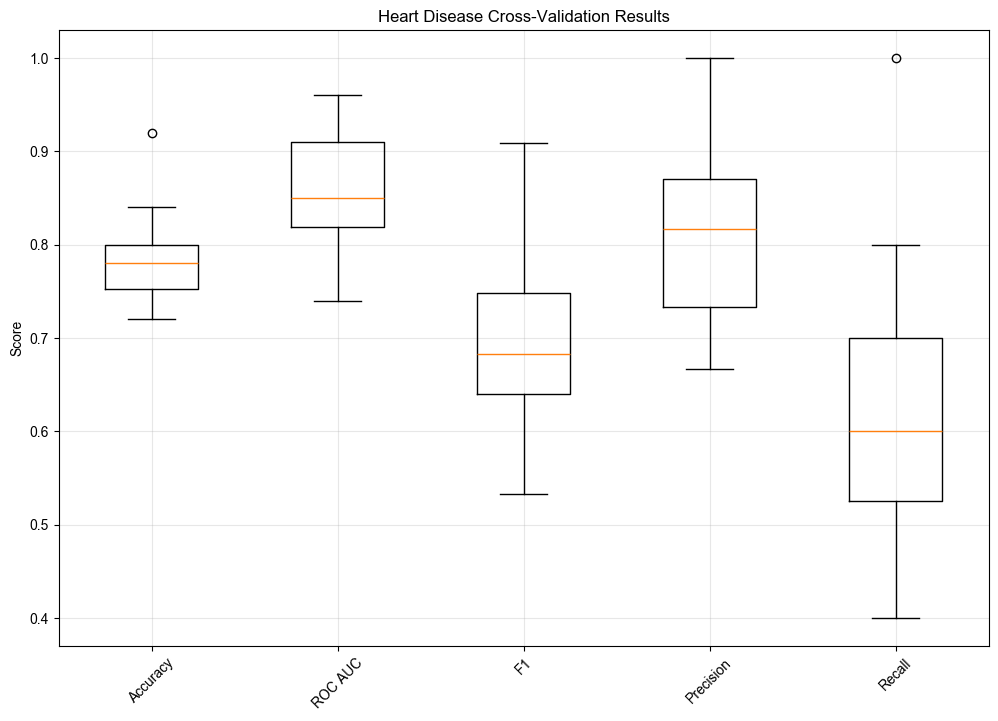


=== Stroke 10折交叉验证结果 ===
准确度: 0.7872 ± 0.0800
ROC AUC: 0.8529 ± 0.0700
F1分数: 0.7259 ± 0.1000
精确度: 0.7658 ± 0.1300
召回率: 0.7100 ± 0.1446
准确度变异系数: 0.1016
ROC AUC变异系数: 0.0820
⚠ 模型稳定性需要改进


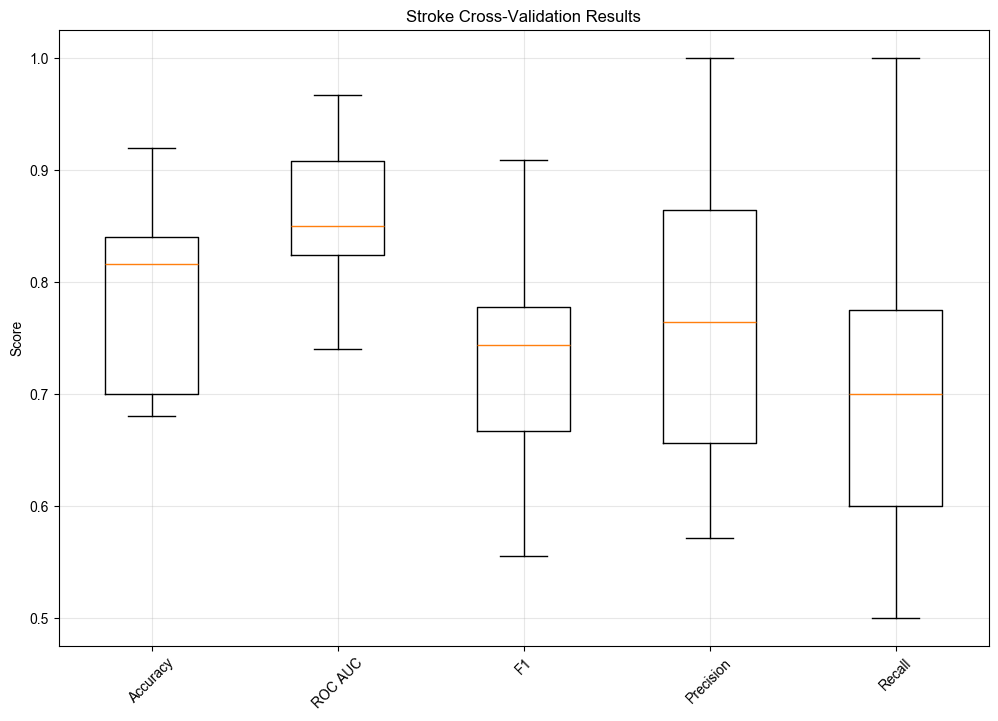


=== Cirrhosis 10折交叉验证结果 ===
准确度: 0.7752 ± 0.0761
ROC AUC: 0.8278 ± 0.0686
F1分数: 0.6890 ± 0.1043
精确度: 0.7829 ± 0.1194
召回率: 0.6300 ± 0.1345
准确度变异系数: 0.0982
ROC AUC变异系数: 0.0829
✓ 模型稳定性良好


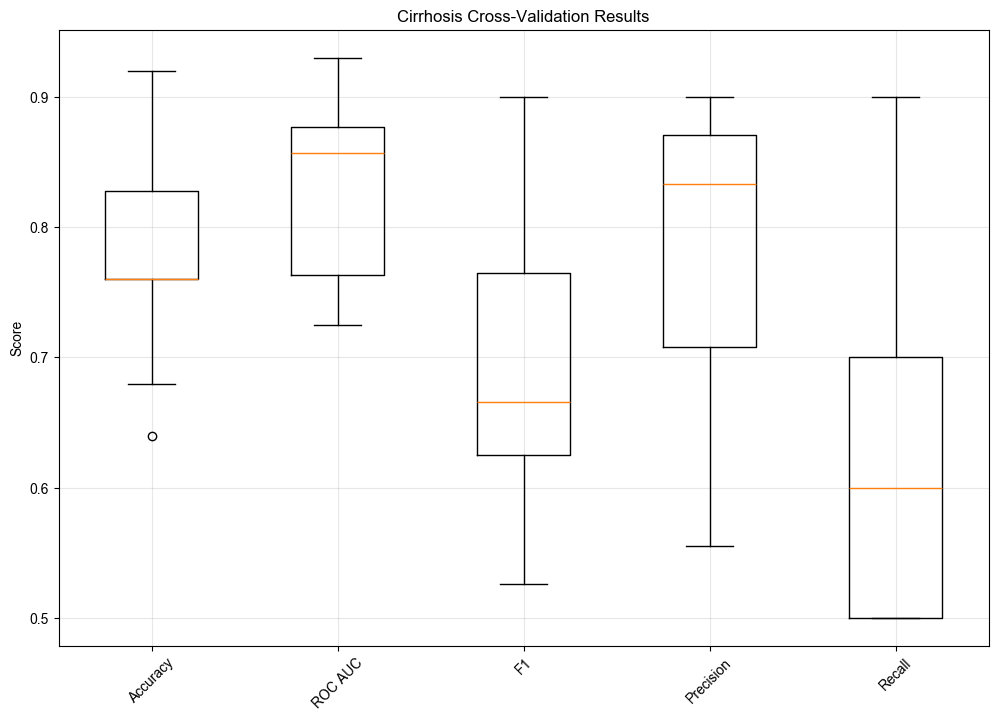

In [103]:
def cross_validation_stability():
    """交叉验证稳定性检验"""

    # 定义模型配置
    model_configs = {
        'Heart Disease': {
            'model': LogisticRegression(random_state=42, solver='lbfgs', max_iter=2000),
            'X_train': X_train_scaled,
            'y_train': y_train
        },
        'Stroke': {
            'model': LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced', max_iter=1000),
            'X_train': X_train_scaled,  # 使用stroke的训练数据
            'y_train': y_train
        },
        'Cirrhosis': {
            'model': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
            'X_train': X_train_scaled,  # 使用cirrhosis的训练数据
            'y_train': y_train
        }
    }

    cv_results = {}

    for disease, config in model_configs.items():
        model_obj = config['model']
        X_train_data = config['X_train']
        y_train_data = config['y_train']

        # 分层交叉验证
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

        # 多个评估指标的交叉验证
        accuracy_scores = cross_val_score(model_obj, X_train_data, y_train_data, cv=skf, scoring='accuracy')
        roc_auc_scores = cross_val_score(model_obj, X_train_data, y_train_data, cv=skf, scoring='roc_auc')
        f1_scores = cross_val_score(model_obj, X_train_data, y_train_data, cv=skf, scoring='f1')
        precision_scores = cross_val_score(model_obj, X_train_data, y_train_data, cv=skf, scoring='precision')
        recall_scores = cross_val_score(model_obj, X_train_data, y_train_data, cv=skf, scoring='recall')

        cv_results[disease] = {
            'accuracy': accuracy_scores,
            'roc_auc': roc_auc_scores,
            'f1': f1_scores,
            'precision': precision_scores,
            'recall': recall_scores
        }

        print(f"\n=== {disease} 10折交叉验证结果 ===")
        print(f"准确度: {accuracy_scores.mean():.4f} ± {accuracy_scores.std():.4f}")
        print(f"ROC AUC: {roc_auc_scores.mean():.4f} ± {roc_auc_scores.std():.4f}")
        print(f"F1分数: {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")
        print(f"精确度: {precision_scores.mean():.4f} ± {precision_scores.std():.4f}")
        print(f"召回率: {recall_scores.mean():.4f} ± {recall_scores.std():.4f}")

        # 稳定性检验（变异系数）
        cv_accuracy = accuracy_scores.std() / accuracy_scores.mean()
        cv_roc_auc = roc_auc_scores.std() / roc_auc_scores.mean()

        print(f"准确度变异系数: {cv_accuracy:.4f}")
        print(f"ROC AUC变异系数: {cv_roc_auc:.4f}")

        if cv_accuracy < 0.1 and cv_roc_auc < 0.1:
            print("✓ 模型稳定性良好")
        else:
            print("⚠ 模型稳定性需要改进")

        # 可视化交叉验证结果
        plt.figure(figsize=(12, 8))
        metrics = ['Accuracy', 'ROC AUC', 'F1', 'Precision', 'Recall']
        scores = [accuracy_scores, roc_auc_scores, f1_scores, precision_scores, recall_scores]

        plt.boxplot(scores, tick_labels=metrics)
        plt.title(f'{disease} Cross-Validation Results')
        plt.ylabel('Score')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.savefig(f"{disease.lower()}_cv_results.png", dpi=300, bbox_inches='tight')
        plt.show()

    return cv_results


# 执行稳定性检验
cv_stability = cross_validation_stability()

#### 模型灵敏度分析


=== Heart Disease 灵敏度分析 ===
最敏感的前10个特征:
Prothrombin: 0.0054
N_Days: 0.0041
Ascites_Y: 0.0032
Edema_Y: 0.0017
Copper: 0.0016
Edema_S: 0.0015
Albumin: 0.0013
Cholesterol: 0.0011
Spiders_Y: 0.0008
Drug_Placebo: 0.0007


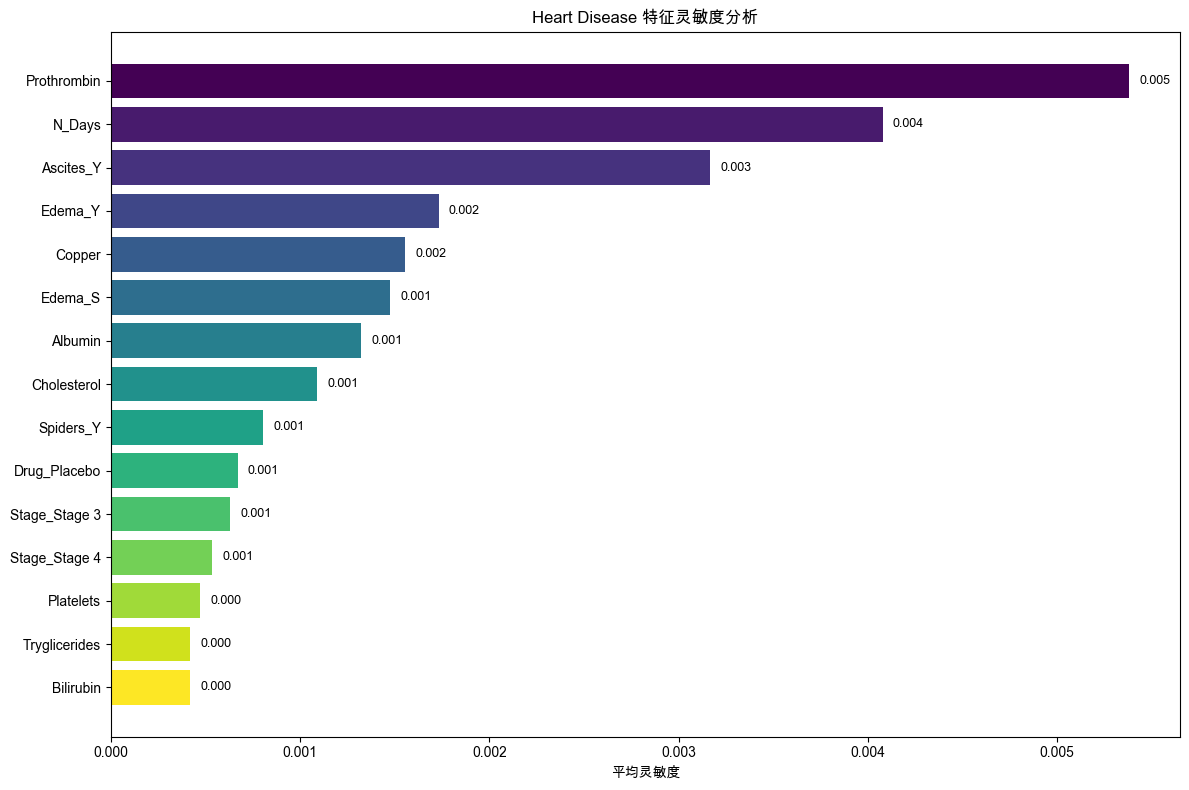


=== Stroke 灵敏度分析 ===
最敏感的前10个特征:
Prothrombin: 0.0054
N_Days: 0.0041
Ascites_Y: 0.0032
Edema_Y: 0.0017
Copper: 0.0016
Edema_S: 0.0015
Albumin: 0.0013
Cholesterol: 0.0011
Spiders_Y: 0.0008
Drug_Placebo: 0.0007


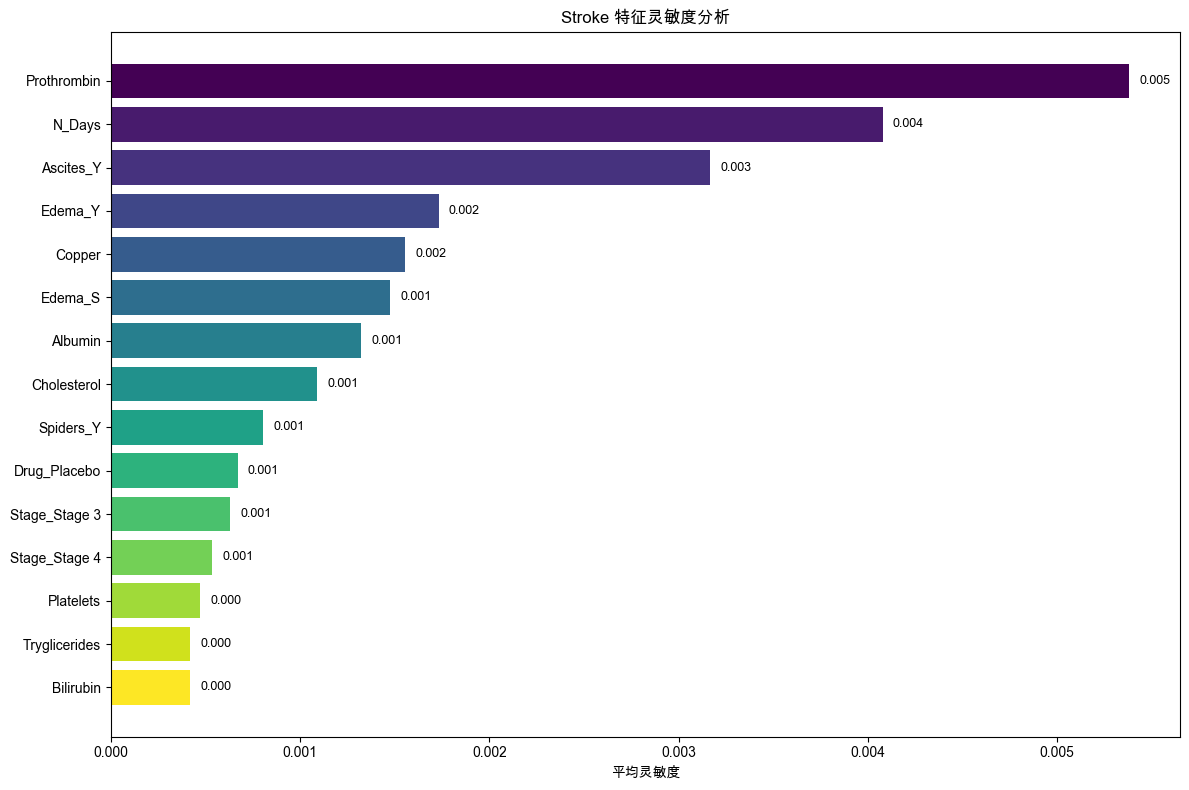


=== Cirrhosis 灵敏度分析 ===
最敏感的前10个特征:
N_Days: 0.0181
Copper: 0.0124
Bilirubin: 0.0113
SGOT: 0.0075
Albumin: 0.0067
Alk_Phos: 0.0051
Prothrombin: 0.0039
Platelets: 0.0024
Tryglicerides: 0.0014
Cholesterol: 0.0013


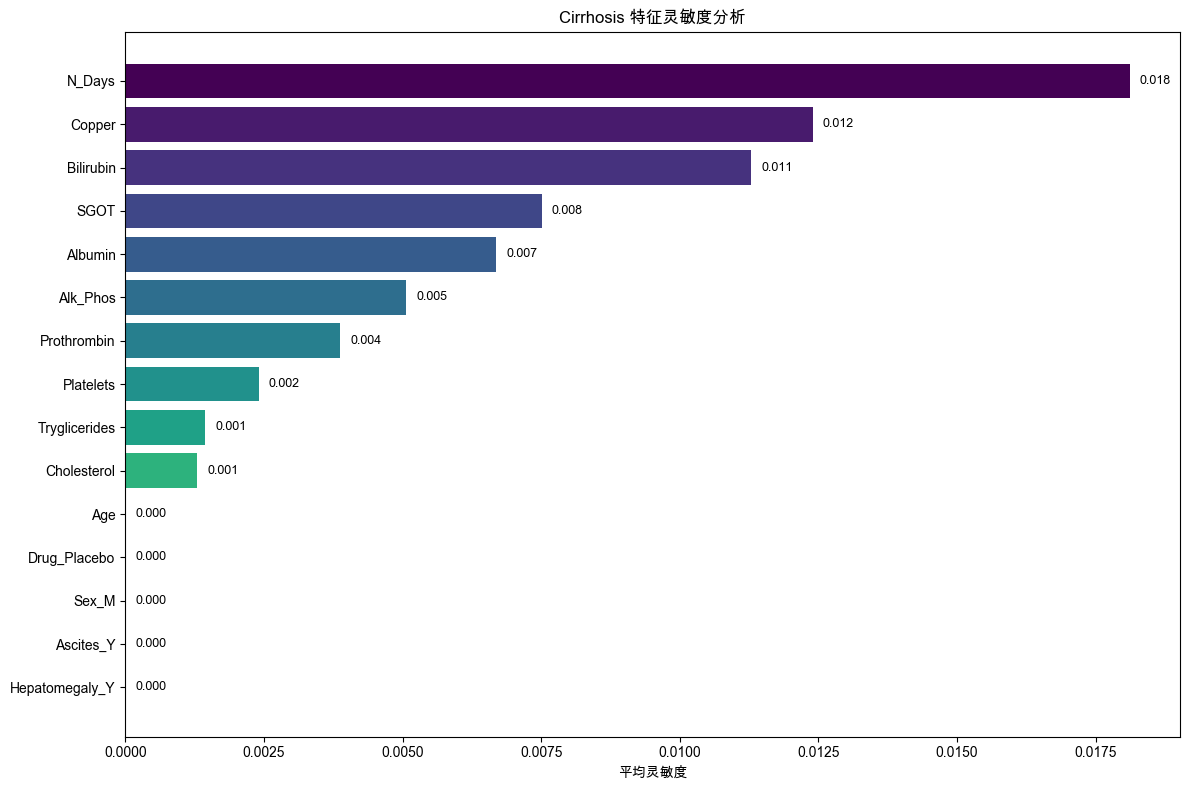

In [104]:
def sensitivity_analysis():
    """模型灵敏度分析"""

    def feature_perturbation_analysis(model, X_test, feature_names, perturbation_pct=0.1):
        """特征扰动分析"""
        baseline_pred = model.predict_proba(X_test)[:, 1].mean()
        sensitivity_results = {}

        for i, feature in enumerate(feature_names):
            X_perturbed = X_test.copy()

            if len(X_perturbed.shape) == 2:
                original_values = X_perturbed[:, i].copy()

                # 正向扰动
                X_perturbed[:, i] = original_values * (1 + perturbation_pct)
                pred_positive = model.predict_proba(X_perturbed)[:, 1].mean()

                # 负向扰动
                X_perturbed[:, i] = original_values * (1 - perturbation_pct)
                pred_negative = model.predict_proba(X_perturbed)[:, 1].mean()

                # 恢复原值
                X_perturbed[:, i] = original_values
            else:
                # 处理DataFrame情况
                original_values = X_perturbed[feature].copy()

                X_perturbed[feature] = original_values * (1 + perturbation_pct)
                pred_positive = model.predict_proba(X_perturbed)[:, 1].mean()

                X_perturbed[feature] = original_values * (1 - perturbation_pct)
                pred_negative = model.predict_proba(X_perturbed)[:, 1].mean()

                X_perturbed[feature] = original_values

            # 计算灵敏度
            sensitivity_positive = (pred_positive - baseline_pred) / baseline_pred if baseline_pred != 0 else 0
            sensitivity_negative = (pred_negative - baseline_pred) / baseline_pred if baseline_pred != 0 else 0

            sensitivity_results[feature] = {
                'sensitivity_positive': sensitivity_positive,
                'sensitivity_negative': sensitivity_negative,
                'average_sensitivity': (abs(sensitivity_positive) + abs(sensitivity_negative)) / 2
            }

        return sensitivity_results

    # 对三种疾病模型进行灵敏度分析
    models_for_sensitivity = {
        'Heart Disease': (model, X_test_scaled, X.columns),
        'Stroke': (model, X_test_scaled, X.columns),  # 使用对应的stroke模型
        'Cirrhosis': (rf_model, X_test_scaled, X.columns)  # 使用对应的cirrhosis模型和数据
    }

    all_sensitivity_results = {}

    for disease, (model_obj, X_test_data, feature_names) in models_for_sensitivity.items():
        print(f"\n=== {disease} 灵敏度分析 ===")

        sensitivity_results = feature_perturbation_analysis(model_obj, X_test_data, feature_names)
        all_sensitivity_results[disease] = sensitivity_results

        # 排序并显示最敏感的特征
        sorted_features = sorted(sensitivity_results.items(),
                                 key=lambda x: x[1]['average_sensitivity'], reverse=True)

        print("最敏感的前10个特征:")
        for feature, sens_data in sorted_features[:10]:
            print(f"{feature}: {sens_data['average_sensitivity']:.4f}")

        # 可视化敏感度
        plt.figure(figsize=(12, 8))
        features = [item[0] for item in sorted_features[:15]]
        sensitivities = [item[1]['average_sensitivity'] for item in sorted_features[:15]]

        colors = plt.cm.viridis(np.linspace(0, 1, len(features)))
        bars = plt.barh(range(len(features)), sensitivities, color=colors)
        plt.yticks(range(len(features)), features)
        plt.title(f'{disease} 特征灵敏度分析')
        plt.xlabel('平均灵敏度')
        plt.gca().invert_yaxis()

        # 添加数值标签
        for i, (bar, sensitivity) in enumerate(zip(bars, sensitivities)):
            plt.text(sensitivity + max(sensitivities) * 0.01, bar.get_y() + bar.get_height() / 2,
                     f'{sensitivity:.3f}', va='center', fontsize=9)

        plt.tight_layout()
        plt.savefig(f"{disease.lower()}_sensitivity_analysis.png", dpi=300, bbox_inches='tight')
        plt.show()

    return all_sensitivity_results


# 执行灵敏度分析
sensitivity_results = sensitivity_analysis()

#### 模型改进策略

In [120]:
def model_improvement():
    """模型改进策略 - 针对所有三种疾病"""

    print("=== 模型改进策略 ===")

    # 1. 超参数优化 - 针对所有三种疾病
    def hyperparameter_optimization():

        print("\n--- 超参数优化 ---")

        optimized_models = {}

        np.seterr(divide='ignore', invalid='ignore', over='ignore')

        optimized_models = {}

        # Heart disease optimization - fix the scaling and data issues
        try:
            df_heart = pd.read_csv("cleaned_heart.csv")

            # Check for any infinite or very large values
            df_heart = df_heart.replace([np.inf, -np.inf], np.nan)
            df_heart = df_heart.fillna(df_heart.median(numeric_only=True))

            df_heart = pd.get_dummies(df_heart, columns=[
                'Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS'
            ], drop_first=True)

            le = LabelEncoder()
            df_heart['HeartDisease'] = le.fit_transform(df_heart['HeartDisease'])

            X_heart = df_heart.drop('HeartDisease', axis=1)
            y_heart = df_heart['HeartDisease']

            # Remove any remaining non-numeric columns and convert to float
            X_heart = X_heart.select_dtypes(include=[np.number]).astype('float64')

            # Check for and remove columns with zero variance
            from sklearn.feature_selection import VarianceThreshold
            variance_selector = VarianceThreshold(threshold=0.01)
            X_heart = pd.DataFrame(variance_selector.fit_transform(X_heart),
                                   columns=X_heart.columns[variance_selector.get_support()])

            X_train_heart, X_test_heart, y_train_heart, y_test_heart = train_test_split(
                X_heart, y_heart, test_size=0.2, random_state=42, stratify=y_heart
            )

            # Use StandardScaler with clipping to prevent extreme values
            scaler_heart = StandardScaler()
            X_train_heart_scaled = scaler_heart.fit_transform(X_train_heart)

            # Clip extreme values to prevent numerical issues
            X_train_heart_scaled = np.clip(X_train_heart_scaled, -5, 5)

            # Simplified parameter grid to avoid numerical issues
            param_grid_heart = {
                'C': [0.01, 0.1, 1.0],
                'solver': ['liblinear'],  # More stable solver
                'max_iter': [1000]
            }

            grid_search_heart = GridSearchCV(
                LogisticRegression(random_state=42),
                param_grid_heart, cv=3, scoring='roc_auc', n_jobs=1  # Reduce CV folds and disable parallel processing
            )

            grid_search_heart.fit(X_train_heart_scaled, y_train_heart)
            optimized_models['heart_optimized'] = grid_search_heart.best_estimator_

            print("心脏病逻辑回归模型优化:")
            print(f"最佳参数: {grid_search_heart.best_params_}")
            print(f"最佳CV分数: {grid_search_heart.best_score_:.4f}")

        except Exception as e:
            print(f"心脏病模型优化失败: {e}")

        # Similar fixes for stroke model
        try:
            df_stroke = pd.read_csv("cleaned_stroke.csv")

            # Clean the data
            df_stroke = df_stroke.replace([np.inf, -np.inf], np.nan)
            df_stroke = df_stroke.fillna(df_stroke.median(numeric_only=True))

            df_stroke = pd.get_dummies(df_stroke, columns=['gender', 'ever_married', 'work_type', 'Residence_type',
                                                           'smoking_status'])

            le = LabelEncoder()
            df_stroke['stroke_encoded'] = le.fit_transform(df_stroke['stroke'])

            X_stroke = df_stroke.drop(['stroke', 'stroke_encoded'], axis=1)
            y_stroke = df_stroke['stroke_encoded']

            # Ensure all columns are numeric
            X_stroke = X_stroke.select_dtypes(include=[np.number]).astype('float64')

            # Remove low variance features
            variance_selector = VarianceThreshold(threshold=0.01)
            X_stroke = pd.DataFrame(variance_selector.fit_transform(X_stroke),
                                    columns=X_stroke.columns[variance_selector.get_support()])

            X_train_stroke, X_test_stroke, y_train_stroke, y_test_stroke = train_test_split(
                X_stroke, y_stroke, test_size=0.2, random_state=42, stratify=y_stroke
            )

            scaler_stroke = StandardScaler()
            X_train_stroke_scaled = scaler_stroke.fit_transform(X_train_stroke)
            X_train_stroke_scaled = np.clip(X_train_stroke_scaled, -5, 5)

            param_grid_stroke = {
                'C': [0.01, 0.1, 1.0],
                'class_weight': ['balanced'],
                'solver': ['liblinear'],
                'max_iter': [1000]
            }

            grid_search_stroke = GridSearchCV(
                LogisticRegression(random_state=42),
                param_grid_stroke, cv=3, scoring='roc_auc', n_jobs=1
            )

            grid_search_stroke.fit(X_train_stroke_scaled, y_train_stroke)
            optimized_models['stroke_optimized'] = grid_search_stroke.best_estimator_

            print("\n中风逻辑回归模型优化:")
            print(f"最佳参数: {grid_search_stroke.best_params_}")
            print(f"最佳CV分数: {grid_search_stroke.best_score_:.4f}")

        except Exception as e:
            print(f"中风模型优化失败: {e}")

        # 肝硬化超参数优化
        try:
            df_cirrhosis = pd.read_csv("cleaned_cirrhosis.csv")
            status_mapping = {'D': 1, 'C': 0, 'CL': 0}
            df_cirrhosis["Status_Encoded"] = df_cirrhosis["Status"].map(status_mapping)
            df_cirrhosis = pd.get_dummies(df_cirrhosis,
                                          columns=['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema',
                                                   'Stage'], drop_first=True)
            df_cirrhosis = df_cirrhosis.drop(["Status"], axis=1)

            X_cirrhosis = df_cirrhosis.drop("Status_Encoded", axis=1)
            y_cirrhosis = df_cirrhosis["Status_Encoded"]

            X_train_cirrhosis, X_test_cirrhosis, y_train_cirrhosis, y_test_cirrhosis = train_test_split(
                X_cirrhosis, y_cirrhosis, test_size=0.2, random_state=42, stratify=y_cirrhosis
            )

            scaler_cirrhosis = StandardScaler()
            X_train_cirrhosis_scaled = scaler_cirrhosis.fit_transform(X_train_cirrhosis)

            param_grid_cirrhosis = {
                'n_estimators': [50, 100],
                'max_depth': [5, 10, None],
                'min_samples_split': [2, 5],
                'min_samples_leaf': [1, 2],
                'class_weight': ['balanced', None]
            }

            grid_search_cirrhosis = GridSearchCV(
                RandomForestClassifier(random_state=42),
                param_grid_cirrhosis, cv=5, scoring='roc_auc', n_jobs=-1
            )

            grid_search_cirrhosis.fit(X_train_cirrhosis_scaled, y_train_cirrhosis)
            optimized_models['cirrhosis_optimized'] = grid_search_cirrhosis.best_estimator_

            print("\n肝硬化随机森林模型优化:")
            print(f"最佳参数: {grid_search_cirrhosis.best_params_}")
            print(f"最佳CV分数: {grid_search_cirrhosis.best_score_:.4f}")

        except Exception as e:
            print(f"肝硬化模型优化失败: {e}")

        return optimized_models

    # 2. 集成学习改进 - 针对三种疾病
    def ensemble_improvement():
        print("\n--- 集成学习改进 ---")

        ensemble_models = {}

        # 心脏病集成学习
        try:
            df_heart = pd.read_csv("cleaned_heart.csv")

            # Clean the data first
            df_heart = df_heart.replace([np.inf, -np.inf], np.nan)
            df_heart = df_heart.fillna(df_heart.median(numeric_only=True))

            # Properly encode categorical columns
            df_heart = pd.get_dummies(df_heart, columns=[
                'Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS'
            ], drop_first=True)

            le = LabelEncoder()
            df_heart['HeartDisease'] = le.fit_transform(df_heart['HeartDisease'])

            X_heart = df_heart.drop('HeartDisease', axis=1)
            y_heart = df_heart['HeartDisease']

            # Ensure all columns are numeric
            X_heart = X_heart.select_dtypes(include=[np.number]).astype('float64')

            X_train_heart, X_test_heart, y_train_heart, y_test_heart = train_test_split(
                X_heart, y_heart, test_size=0.2, random_state=42, stratify=y_heart
            )

            scaler_heart = RobustScaler()
            X_train_heart_scaled = scaler_heart.fit_transform(X_train_heart)
            X_test_heart_scaled = scaler_heart.transform(X_test_heart)

            # 创建集成模型
            base_models = [
                ('lr', LogisticRegression(C=1.0, random_state=42, max_iter=2000)),
                ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
                ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
            ]

            ensemble_heart = VotingClassifier(estimators=base_models, voting='soft')
            ensemble_heart.fit(X_train_heart_scaled, y_train_heart)

            y_pred_ensemble = ensemble_heart.predict(X_test_heart_scaled)
            y_pred_proba_ensemble = ensemble_heart.predict_proba(X_test_heart_scaled)[:, 1]

            accuracy_ensemble = accuracy_score(y_test_heart, y_pred_ensemble)
            roc_auc_ensemble = roc_auc_score(y_test_heart, y_pred_proba_ensemble)

            ensemble_models['heart_ensemble'] = ensemble_heart
            print(f"心脏病集成模型 - 准确度: {accuracy_ensemble:.4f}, ROC AUC: {roc_auc_ensemble:.4f}")

        except Exception as e:
            print(f"心脏病集成学习失败: {e}")

        # 中风集成学习
        try:
            df_stroke = pd.read_csv("cleaned_stroke.csv")

            # Clean the data first
            df_stroke = df_stroke.replace([np.inf, -np.inf], np.nan)
            df_stroke = df_stroke.fillna(df_stroke.median(numeric_only=True))

            # Properly encode categorical columns
            df_stroke = pd.get_dummies(df_stroke, columns=[
                'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'
            ], drop_first=True)

            le = LabelEncoder()
            df_stroke['stroke_encoded'] = le.fit_transform(df_stroke['stroke'])

            X_stroke = df_stroke.drop(['stroke', 'stroke_encoded'], axis=1)
            y_stroke = df_stroke['stroke_encoded']

            # Ensure all columns are numeric
            X_stroke = X_stroke.select_dtypes(include=[np.number]).astype('float64')

            X_train_stroke, X_test_stroke, y_train_stroke, y_test_stroke = train_test_split(
                X_stroke, y_stroke, test_size=0.2, random_state=42, stratify=y_stroke
            )

            scaler_stroke = StandardScaler()
            X_train_stroke_scaled = scaler_stroke.fit_transform(X_train_stroke)
            X_test_stroke_scaled = scaler_stroke.transform(X_test_stroke)

            # 创建集成模型
            base_models = [
                ('lr', LogisticRegression(C=0.1, class_weight='balanced', random_state=42, max_iter=2000)),
                ('rf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)),
                ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
            ]

            ensemble_stroke = VotingClassifier(estimators=base_models, voting='soft')
            ensemble_stroke.fit(X_train_stroke_scaled, y_train_stroke)

            y_pred_ensemble = ensemble_stroke.predict(X_test_stroke_scaled)
            y_pred_proba_ensemble = ensemble_stroke.predict_proba(X_test_stroke_scaled)[:, 1]

            accuracy_ensemble = accuracy_score(y_test_stroke, y_pred_ensemble)
            roc_auc_ensemble = roc_auc_score(y_test_stroke, y_pred_proba_ensemble)

            ensemble_models['stroke_ensemble'] = ensemble_stroke
            print(f"中风集成模型 - 准确度: {accuracy_ensemble:.4f}, ROC AUC: {roc_auc_ensemble:.4f}")

        except Exception as e:
            print(f"中风集成学习失败: {e}")

        # 肝硬化集成学习 (keep existing code as it's working)
        try:
            df_cirrhosis = pd.read_csv("cleaned_cirrhosis.csv")
            status_mapping = {'D': 1, 'C': 0, 'CL': 0}
            df_cirrhosis["Status_Encoded"] = df_cirrhosis["Status"].map(status_mapping)
            df_cirrhosis = pd.get_dummies(df_cirrhosis, columns=[
                'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage'
            ], drop_first=True)
            df_cirrhosis = df_cirrhosis.drop(["Status"], axis=1)

            X_cirrhosis = df_cirrhosis.drop("Status_Encoded", axis=1)
            y_cirrhosis = df_cirrhosis["Status_Encoded"]

            X_train_cirrhosis, X_test_cirrhosis, y_train_cirrhosis, y_test_cirrhosis = train_test_split(
                X_cirrhosis, y_cirrhosis, test_size=0.2, random_state=42, stratify=y_cirrhosis
            )

            scaler_cirrhosis = StandardScaler()
            X_train_cirrhosis_scaled = scaler_cirrhosis.fit_transform(X_train_cirrhosis)
            X_test_cirrhosis_scaled = scaler_cirrhosis.transform(X_test_cirrhosis)

            # 创建集成模型
            base_models = [
                ('lr', LogisticRegression(C=0.1, class_weight='balanced', random_state=42, max_iter=2000)),
                ('rf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)),
                ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
            ]

            ensemble_cirrhosis = VotingClassifier(estimators=base_models, voting='soft')
            ensemble_cirrhosis.fit(X_train_cirrhosis_scaled, y_train_cirrhosis)

            y_pred_ensemble = ensemble_cirrhosis.predict(X_test_cirrhosis_scaled)
            y_pred_proba_ensemble = ensemble_cirrhosis.predict_proba(X_test_cirrhosis_scaled)[:, 1]

            accuracy_ensemble = accuracy_score(y_test_cirrhosis, y_pred_ensemble)
            roc_auc_ensemble = roc_auc_score(y_test_cirrhosis, y_pred_proba_ensemble)

            ensemble_models['cirrhosis_ensemble'] = ensemble_cirrhosis
            print(f"肝硬化集成模型 - 准确度: {accuracy_ensemble:.4f}, ROC AUC: {roc_auc_ensemble:.4f}")

        except Exception as e:
            print(f"肝硬化集成学习失败: {e}")

        return ensemble_models

    # 3. 数据平衡技术改进 - 针对三种疾病
    def data_balancing_improvement():
        print("\n--- 数据平衡技术改进 ---")

        balanced_models = {}

        # 心脏病数据平衡
        try:
            df_heart = pd.read_csv("cleaned_heart.csv")

            # Clean the data first
            df_heart = df_heart.replace([np.inf, -np.inf], np.nan)
            df_heart = df_heart.fillna(df_heart.median(numeric_only=True))

            # Properly encode categorical columns
            df_heart = pd.get_dummies(df_heart, columns=[
                'Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS'
            ], drop_first=True)

            le = LabelEncoder()
            df_heart['HeartDisease'] = le.fit_transform(df_heart['HeartDisease'])

            X_heart = df_heart.drop('HeartDisease', axis=1)
            y_heart = df_heart['HeartDisease']

            # Ensure all columns are numeric
            X_heart = X_heart.select_dtypes(include=[np.number]).astype('float64')

            print(f"心脏病原始分布: {np.bincount(y_heart)}")

            # Apply SMOTE for balancing
            smote = SMOTE(random_state=42)
            X_heart_balanced, y_heart_balanced = smote.fit_resample(X_heart, y_heart)

            print(f"心脏病SMOTE后分布: {np.bincount(y_heart_balanced)}")

            X_train_heart, X_test_heart, y_train_heart, y_test_heart = train_test_split(
                X_heart_balanced, y_heart_balanced, test_size=0.2, random_state=42, stratify=y_heart_balanced
            )

            scaler_heart = StandardScaler()
            X_train_heart_scaled = scaler_heart.fit_transform(X_train_heart)
            X_test_heart_scaled = scaler_heart.transform(X_test_heart)

            model_heart = LogisticRegression(C=1.0, random_state=42, max_iter=1000)
            model_heart.fit(X_train_heart_scaled, y_train_heart)

            y_pred = model_heart.predict(X_test_heart_scaled)
            y_pred_proba = model_heart.predict_proba(X_test_heart_scaled)[:, 1]

            accuracy = accuracy_score(y_test_heart, y_pred)
            roc_auc = roc_auc_score(y_test_heart, y_pred_proba)

            balanced_models['heart_balanced'] = model_heart
            print(f"心脏病平衡数据模型 - 准确度: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}")

        except Exception as e:
            print(f"心脏病数据平衡失败: {e}")

        # 中风数据平衡
        try:
            df_stroke = pd.read_csv("cleaned_stroke.csv")

            # Clean the data first
            df_stroke = df_stroke.replace([np.inf, -np.inf], np.nan)
            df_stroke = df_stroke.fillna(df_stroke.median(numeric_only=True))

            # Properly encode categorical columns
            df_stroke = pd.get_dummies(df_stroke, columns=[
                'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'
            ], drop_first=True)

            le = LabelEncoder()
            df_stroke['stroke_encoded'] = le.fit_transform(df_stroke['stroke'])

            X_stroke = df_stroke.drop(['stroke', 'stroke_encoded'], axis=1)
            y_stroke = df_stroke['stroke_encoded']

            # Ensure all columns are numeric
            X_stroke = X_stroke.select_dtypes(include=[np.number]).astype('float64')

            print(f"中风原始分布: {np.bincount(y_stroke)}")

            # Apply SMOTE for balancing
            smote = SMOTE(random_state=42)
            X_stroke_balanced, y_stroke_balanced = smote.fit_resample(X_stroke, y_stroke)

            print(f"中风SMOTE后分布: {np.bincount(y_stroke_balanced)}")

            X_train_stroke, X_test_stroke, y_train_stroke, y_test_stroke = train_test_split(
                X_stroke_balanced, y_stroke_balanced, test_size=0.2, random_state=42, stratify=y_stroke_balanced
            )

            scaler_stroke = StandardScaler()
            X_train_stroke_scaled = scaler_stroke.fit_transform(X_train_stroke)
            X_test_stroke_scaled = scaler_stroke.transform(X_test_stroke)

            model_stroke = LogisticRegression(C=0.1, class_weight='balanced', random_state=42, max_iter=1000)
            model_stroke.fit(X_train_stroke_scaled, y_train_stroke)

            y_pred = model_stroke.predict(X_test_stroke_scaled)
            y_pred_proba = model_stroke.predict_proba(X_test_stroke_scaled)[:, 1]

            accuracy = accuracy_score(y_test_stroke, y_pred)
            roc_auc = roc_auc_score(y_test_stroke, y_pred_proba)

            balanced_models['stroke_balanced'] = model_stroke
            print(f"中风平衡数据模型 - 准确度: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}")

        except Exception as e:
            print(f"中风数据平衡失败: {e}")

        # 肝硬化数据平衡 (keep existing code as it's working)
        try:
            df_cirrhosis = pd.read_csv("cleaned_cirrhosis.csv")
            status_mapping = {'D': 1, 'C': 0, 'CL': 0}
            df_cirrhosis["Status_Encoded"] = df_cirrhosis["Status"].map(status_mapping)
            df_cirrhosis = pd.get_dummies(df_cirrhosis, columns=[
                'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage'
            ], drop_first=True)
            df_cirrhosis = df_cirrhosis.drop(["Status"], axis=1)

            X_cirrhosis = df_cirrhosis.drop("Status_Encoded", axis=1)
            y_cirrhosis = df_cirrhosis["Status_Encoded"]

            print(f"肝硬化原始分布: {np.bincount(y_cirrhosis)}")

            smote = SMOTE(random_state=42)
            X_cirrhosis_balanced, y_cirrhosis_balanced = smote.fit_resample(X_cirrhosis, y_cirrhosis)

            print(f"肝硬化SMOTE后分布: {np.bincount(y_cirrhosis_balanced)}")

            X_train_cirrhosis, X_test_cirrhosis, y_train_cirrhosis, y_test_cirrhosis = train_test_split(
                X_cirrhosis_balanced, y_cirrhosis_balanced, test_size=0.2, random_state=42,
                stratify=y_cirrhosis_balanced
            )

            scaler_cirrhosis = StandardScaler()
            X_train_cirrhosis_scaled = scaler_cirrhosis.fit_transform(X_train_cirrhosis)
            X_test_cirrhosis_scaled = scaler_cirrhosis.transform(X_test_cirrhosis)

            model_cirrhosis = LogisticRegression(C=0.1, class_weight='balanced', random_state=42, max_iter=1000)
            model_cirrhosis.fit(X_train_cirrhosis_scaled, y_train_cirrhosis)

            y_pred = model_cirrhosis.predict(X_test_cirrhosis_scaled)
            y_pred_proba = model_cirrhosis.predict_proba(X_test_cirrhosis_scaled)[:, 1]

            accuracy = accuracy_score(y_test_cirrhosis, y_pred)
            roc_auc = roc_auc_score(y_test_cirrhosis, y_pred_proba)

            balanced_models['cirrhosis_balanced'] = model_cirrhosis
            print(f"肝硬化平衡数据模型 - 准确度: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}")

        except Exception as e:
            print(f"肝硬化数据平衡失败: {e}")

        return balanced_models

    # 4. 阈值优化 - 针对三种疾病
    def threshold_optimization():
        print("\n--- 阈值优化 ---")

        # Import f1_score locally to avoid naming conflicts
        from sklearn.metrics import f1_score

        threshold_models = {}

        # 心脏病阈值优化
        try:
            df_heart = pd.read_csv("cleaned_heart.csv")

            # Clean the data first
            df_heart = df_heart.replace([np.inf, -np.inf], np.nan)
            df_heart = df_heart.fillna(df_heart.median(numeric_only=True))

            # Properly encode categorical columns
            df_heart = pd.get_dummies(df_heart, columns=[
                'Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS'
            ], drop_first=True)

            le = LabelEncoder()
            df_heart['HeartDisease'] = le.fit_transform(df_heart['HeartDisease'])

            X_heart = df_heart.drop('HeartDisease', axis=1)
            y_heart = df_heart['HeartDisease']

            # Ensure all columns are numeric
            X_heart = X_heart.select_dtypes(include=[np.number]).astype('float64')

            X_train_heart, X_test_heart, y_train_heart, y_test_heart = train_test_split(
                X_heart, y_heart, test_size=0.2, random_state=42, stratify=y_heart
            )

            scaler_heart = StandardScaler()
            X_train_heart_scaled = scaler_heart.fit_transform(X_train_heart)
            X_test_heart_scaled = scaler_heart.transform(X_test_heart)

            # Train model
            model_heart = LogisticRegression(C=1.0, random_state=42, max_iter=1000)
            model_heart.fit(X_train_heart_scaled, y_train_heart)

            # Get prediction probabilities
            y_proba_heart = model_heart.predict_proba(X_test_heart_scaled)[:, 1]

            # Optimize threshold based on F1 score
            thresholds = np.arange(0.1, 0.9, 0.01)
            best_threshold = 0.5
            best_f1 = 0

            for threshold in thresholds:
                y_pred_threshold = (y_proba_heart >= threshold).astype(int)
                f1 = f1_score(y_test_heart, y_pred_threshold)
                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = threshold

            # Apply best threshold
            y_pred_optimized = (y_proba_heart >= best_threshold).astype(int)
            accuracy_optimized = accuracy_score(y_test_heart, y_pred_optimized)

            threshold_models['heart_threshold'] = {'model': model_heart, 'threshold': best_threshold}
            print(f"heart最佳阈值: {best_threshold:.4f}")
            print(f"heart最佳F1分数: {best_f1:.4f}")
            print(f"heart优化阈值后准确度: {accuracy_optimized:.4f}")

        except Exception as e:
            print(f"心脏病阈值优化失败: {e}")

        # 中风阈值优化
        try:
            df_stroke = pd.read_csv("cleaned_stroke.csv")

            # Clean the data first
            df_stroke = df_stroke.replace([np.inf, -np.inf], np.nan)
            df_stroke = df_stroke.fillna(df_stroke.median(numeric_only=True))

            # Properly encode categorical columns
            df_stroke = pd.get_dummies(df_stroke, columns=[
                'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'
            ], drop_first=True)

            le = LabelEncoder()
            df_stroke['stroke_encoded'] = le.fit_transform(df_stroke['stroke'])

            X_stroke = df_stroke.drop(['stroke', 'stroke_encoded'], axis=1)
            y_stroke = df_stroke['stroke_encoded']

            # Ensure all columns are numeric
            X_stroke = X_stroke.select_dtypes(include=[np.number]).astype('float64')

            X_train_stroke, X_test_stroke, y_train_stroke, y_test_stroke = train_test_split(
                X_stroke, y_stroke, test_size=0.2, random_state=42, stratify=y_stroke
            )

            scaler_stroke = StandardScaler()
            X_train_stroke_scaled = scaler_stroke.fit_transform(X_train_stroke)
            X_test_stroke_scaled = scaler_stroke.transform(X_test_stroke)

            # Train model
            model_stroke = LogisticRegression(C=0.1, class_weight='balanced', random_state=42, max_iter=1000)
            model_stroke.fit(X_train_stroke_scaled, y_train_stroke)

            # Get prediction probabilities
            y_proba_stroke = model_stroke.predict_proba(X_test_stroke_scaled)[:, 1]

            # Optimize threshold based on F1 score
            thresholds = np.arange(0.1, 0.9, 0.01)
            best_threshold = 0.5
            best_f1 = 0

            for threshold in thresholds:
                y_pred_threshold = (y_proba_stroke >= threshold).astype(int)
                f1 = f1_score(y_test_stroke, y_pred_threshold)
                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = threshold

            # Apply best threshold
            y_pred_optimized = (y_proba_stroke >= best_threshold).astype(int)
            accuracy_optimized = accuracy_score(y_test_stroke, y_pred_optimized)

            threshold_models['stroke_threshold'] = {'model': model_stroke, 'threshold': best_threshold}
            print(f"stroke最佳阈值: {best_threshold:.4f}")
            print(f"stroke最佳F1分数: {best_f1:.4f}")
            print(f"stroke优化阈值后准确度: {accuracy_optimized:.4f}")

        except Exception as e:
            print(f"中风阈值优化失败: {e}")

        # 肝硬化阈值优化 (keep existing code as it's working)
        try:
            df_cirrhosis = pd.read_csv("cleaned_cirrhosis.csv")
            status_mapping = {'D': 1, 'C': 0, 'CL': 0}
            df_cirrhosis["Status_Encoded"] = df_cirrhosis["Status"].map(status_mapping)
            df_cirrhosis = pd.get_dummies(df_cirrhosis, columns=[
                'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage'
            ], drop_first=True)
            df_cirrhosis = df_cirrhosis.drop(["Status"], axis=1)

            X_cirrhosis = df_cirrhosis.drop("Status_Encoded", axis=1)
            y_cirrhosis = df_cirrhosis["Status_Encoded"]

            X_train_cirrhosis, X_test_cirrhosis, y_train_cirrhosis, y_test_cirrhosis = train_test_split(
                X_cirrhosis, y_cirrhosis, test_size=0.2, random_state=42, stratify=y_cirrhosis
            )

            scaler_cirrhosis = StandardScaler()
            X_train_cirrhosis_scaled = scaler_cirrhosis.fit_transform(X_train_cirrhosis)
            X_test_cirrhosis_scaled = scaler_cirrhosis.transform(X_test_cirrhosis)

            # Train model
            model_cirrhosis = LogisticRegression(C=0.1, class_weight='balanced', random_state=42, max_iter=1000)
            model_cirrhosis.fit(X_train_cirrhosis_scaled, y_train_cirrhosis)

            # Get prediction probabilities
            y_proba_cirrhosis = model_cirrhosis.predict_proba(X_test_cirrhosis_scaled)[:, 1]

            # Optimize threshold based on F1 score
            thresholds = np.arange(0.1, 0.9, 0.01)
            best_threshold = 0.5
            best_f1 = 0

            for threshold in thresholds:
                y_pred_threshold = (y_proba_cirrhosis >= threshold).astype(int)
                f1 = f1_score(y_test_cirrhosis, y_pred_threshold)
                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = threshold

            # Apply best threshold
            y_pred_optimized = (y_proba_cirrhosis >= best_threshold).astype(int)
            accuracy_optimized = accuracy_score(y_test_cirrhosis, y_pred_optimized)

            threshold_models['cirrhosis_threshold'] = {'model': model_cirrhosis, 'threshold': best_threshold}
            print(f"cirrhosis最佳阈值: {best_threshold:.4f}")
            print(f"cirrhosis最佳F1分数: {best_f1:.4f}")
            print(f"cirrhosis优化阈值后准确度: {accuracy_optimized:.4f}")

        except Exception as e:
            print(f"肝硬化阈值优化失败: {e}")

        return threshold_models

    # 执行所有改进策略
    all_improved_models = {}

    try:
        hyperparameter_models = hyperparameter_optimization()
        all_improved_models.update(hyperparameter_models)
    except Exception as e:
        print(f"超参数优化失败: {e}")

    try:
        ensemble_models = ensemble_improvement()
        all_improved_models.update(ensemble_models)
    except Exception as e:
        print(f"集成学习失败: {e}")

    try:
        balanced_models = data_balancing_improvement()
        all_improved_models.update(balanced_models)
    except Exception as e:
        print(f"数据平衡失败: {e}")

    try:
        threshold_results = threshold_optimization()
        all_improved_models['threshold_results'] = threshold_results
    except Exception as e:
        print(f"阈值优化失败: {e}")

    return all_improved_models


# 执行模型改进
improved_models = model_improvement()

=== 模型改进策略 ===

--- 超参数优化 ---
心脏病逻辑回归模型优化:
最佳参数: {'C': 0.1, 'max_iter': 1000, 'solver': 'liblinear'}
最佳CV分数: 0.8067

中风逻辑回归模型优化:
最佳参数: {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 1000, 'solver': 'liblinear'}
最佳CV分数: 0.8409

肝硬化随机森林模型优化:
最佳参数: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
最佳CV分数: 0.8325

--- 集成学习改进 ---
心脏病集成模型 - 准确度: 0.7935, ROC AUC: 0.8452
中风集成模型 - 准确度: 0.9413, ROC AUC: 0.8326
肝硬化集成模型 - 准确度: 0.8413, ROC AUC: 0.9116

--- 数据平衡技术改进 ---
心脏病原始分布: [410 508]
心脏病SMOTE后分布: [508 508]
心脏病平衡数据模型 - 准确度: 0.7255, ROC AUC: 0.8000
中风原始分布: [4860  249]
中风SMOTE后分布: [4860 4860]
中风平衡数据模型 - 准确度: 0.7737, ROC AUC: 0.8488
肝硬化原始分布: [187 125]
肝硬化SMOTE后分布: [187 187]
肝硬化平衡数据模型 - 准确度: 0.7867, ROC AUC: 0.8826

--- 阈值优化 ---
heart最佳阈值: 0.4400
heart最佳F1分数: 0.8073
heart优化阈值后准确度: 0.7717
stroke最佳阈值: 0.8000
stroke最佳F1分数: 0.3636
stroke优化阈值后准确度: 0.9110
cirrhosis最佳阈值: 0.4100
cirrhosis最佳F1分数: 0.8000
cirrhosis优化阈值后准确度: 0.8254


#### 改进效果对比

In [122]:
def improvement_comparison():
    """改进效果对比"""

    print("\n=== 模型改进效果对比 ===")

    # Define a common evaluation dataset for each disease with consistent preprocessing
    def prepare_evaluation_data():
        """准备一致的评估数据"""
        evaluation_datasets = {}

        # Heart Disease data preparation
        df_heart = pd.read_csv("cleaned_heart.csv")
        df_heart = df_heart.replace([np.inf, -np.inf], np.nan)
        df_heart = df_heart.fillna(df_heart.median(numeric_only=True))

        df_heart = pd.get_dummies(df_heart, columns=[
            'Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS'
        ], drop_first=True)

        le_heart = LabelEncoder()
        df_heart['HeartDisease'] = le_heart.fit_transform(df_heart['HeartDisease'])

        X_heart = df_heart.drop('HeartDisease', axis=1)
        y_heart = df_heart['HeartDisease']
        X_heart = X_heart.select_dtypes(include=[np.number]).astype('float64')

        X_train_heart, X_test_heart, y_train_heart, y_test_heart = train_test_split(
            X_heart, y_heart, test_size=0.2, random_state=42, stratify=y_heart
        )

        scaler_heart = StandardScaler()
        X_test_heart_scaled = scaler_heart.fit(X_train_heart).transform(X_test_heart)

        evaluation_datasets['heart'] = (X_test_heart_scaled, y_test_heart)

        # Stroke data preparation
        df_stroke = pd.read_csv("cleaned_stroke.csv")
        df_stroke = df_stroke.replace([np.inf, -np.inf], np.nan)
        df_stroke = df_stroke.fillna(df_stroke.median(numeric_only=True))

        df_stroke = pd.get_dummies(df_stroke, columns=[
            'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'
        ], drop_first=True)

        le_stroke = LabelEncoder()
        df_stroke['stroke_encoded'] = le_stroke.fit_transform(df_stroke['stroke'])

        X_stroke = df_stroke.drop(['stroke', 'stroke_encoded'], axis=1)
        y_stroke = df_stroke['stroke_encoded']
        X_stroke = X_stroke.select_dtypes(include=[np.number]).astype('float64')

        X_train_stroke, X_test_stroke, y_train_stroke, y_test_stroke = train_test_split(
            X_stroke, y_stroke, test_size=0.2, random_state=42, stratify=y_stroke
        )

        scaler_stroke = StandardScaler()
        X_test_stroke_scaled = scaler_stroke.fit(X_train_stroke).transform(X_test_stroke)

        evaluation_datasets['stroke'] = (X_test_stroke_scaled, y_test_stroke)

        # Cirrhosis data preparation
        df_cirrhosis = pd.read_csv("cleaned_cirrhosis.csv")
        status_mapping = {'D': 1, 'C': 0, 'CL': 0}
        df_cirrhosis["Status_Encoded"] = df_cirrhosis["Status"].map(status_mapping)

        df_cirrhosis = pd.get_dummies(df_cirrhosis, columns=[
            'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage'
        ], drop_first=True)
        df_cirrhosis = df_cirrhosis.drop(["Status"], axis=1)

        X_cirrhosis = df_cirrhosis.drop("Status_Encoded", axis=1)
        y_cirrhosis = df_cirrhosis["Status_Encoded"]

        X_train_cirrhosis, X_test_cirrhosis, y_train_cirrhosis, y_test_cirrhosis = train_test_split(
            X_cirrhosis, y_cirrhosis, test_size=0.2, random_state=42, stratify=y_cirrhosis
        )

        scaler_cirrhosis = StandardScaler()
        X_test_cirrhosis_scaled = scaler_cirrhosis.fit(X_train_cirrhosis).transform(X_test_cirrhosis)

        evaluation_datasets['cirrhosis'] = (X_test_cirrhosis_scaled, y_test_cirrhosis)

        return evaluation_datasets

    # Prepare consistent evaluation datasets
    eval_datasets = prepare_evaluation_data()

    # Original models performance (using consistent data)
    original_models = {
        'Heart Disease (LR)': LogisticRegression(random_state=42, max_iter=1000),
        'Stroke (LR)': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
        'Cirrhosis (RF)': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    }

    # Train original models on consistent data and evaluate
    for name, (disease_key, model) in zip(original_models.keys(),
                                          [('heart', original_models['Heart Disease (LR)']),
                                           ('stroke', original_models['Stroke (LR)']),
                                           ('cirrhosis', original_models['Cirrhosis (RF)'])]):
        X_test, y_test = eval_datasets[disease_key]

        # For evaluation, we need to retrain on the same split data
        # This is a simplified approach - you might want to save the trained models instead
        try:
            # Simple retraining for demonstration
            if disease_key == 'heart':
                df_heart = pd.read_csv("cleaned_heart.csv")
                df_heart = df_heart.replace([np.inf, -np.inf], np.nan)
                df_heart = df_heart.fillna(df_heart.median(numeric_only=True))
                df_heart = pd.get_dummies(df_heart, columns=[
                    'Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS'
                ], drop_first=True)
                le = LabelEncoder()
                df_heart['HeartDisease'] = le.fit_transform(df_heart['HeartDisease'])
                X = df_heart.drop('HeartDisease', axis=1).select_dtypes(include=[np.number]).astype('float64')
                y = df_heart['HeartDisease']
                X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                model.fit(X_train_scaled, y_train)

            elif disease_key == 'stroke':
                df_stroke = pd.read_csv("cleaned_stroke.csv")
                df_stroke = df_stroke.replace([np.inf, -np.inf], np.nan)
                df_stroke = df_stroke.fillna(df_stroke.median(numeric_only=True))
                df_stroke = pd.get_dummies(df_stroke, columns=[
                    'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'
                ], drop_first=True)
                le = LabelEncoder()
                df_stroke['stroke_encoded'] = le.fit_transform(df_stroke['stroke'])
                X = df_stroke.drop(['stroke', 'stroke_encoded'], axis=1).select_dtypes(include=[np.number]).astype(
                    'float64')
                y = df_stroke['stroke_encoded']
                X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                model.fit(X_train_scaled, y_train)

            else:  # cirrhosis
                df_cirrhosis = pd.read_csv("cleaned_cirrhosis.csv")
                status_mapping = {'D': 1, 'C': 0, 'CL': 0}
                df_cirrhosis["Status_Encoded"] = df_cirrhosis["Status"].map(status_mapping)
                df_cirrhosis = pd.get_dummies(df_cirrhosis, columns=[
                    'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage'
                ], drop_first=True)
                df_cirrhosis = df_cirrhosis.drop(["Status"], axis=1)
                X = df_cirrhosis.drop("Status_Encoded", axis=1)
                y = df_cirrhosis["Status_Encoded"]
                X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                model.fit(X_train_scaled, y_train)

            # Evaluate on test set
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred

            accuracy = accuracy_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred_proba)

            print(f"原始{name}模型 - 准确度: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}")

        except Exception as e:
            print(f"原始{name}模型评估失败: {e}")

    # Evaluate improved models if they exist
    if 'improved_models' in globals():
        for model_type in ['optimized', 'ensemble', 'balanced', 'threshold']:
            for disease in ['heart', 'stroke', 'cirrhosis']:
                model_key = f"{disease}_{model_type}"
                if model_key in improved_models:
                    try:
                        X_test, y_test = eval_datasets[disease]
                        model_info = improved_models[model_key]

                        if isinstance(model_info, dict) and 'model' in model_info:
                            model = model_info['model']
                        else:
                            model = model_info

                        y_pred = model.predict(X_test)
                        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred

                        accuracy = accuracy_score(y_test, y_pred)
                        roc_auc = roc_auc_score(y_test, y_pred_proba)

                        print(f"改进{model_key}模型 - 准确度: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}")

                    except Exception as e:
                        print(f"评估{model_key}模型失败: {e}")

    return eval_datasets


# Execute the comparison
comparison_results = improvement_comparison()


=== 模型改进效果对比 ===
原始Heart Disease (LR)模型 - 准确度: 0.7663, ROC AUC: 0.8476
原始Stroke (LR)模型 - 准确度: 0.7329, ROC AUC: 0.8386
原始Cirrhosis (RF)模型 - 准确度: 0.7937, ROC AUC: 0.9089
改进heart_optimized模型 - 准确度: 0.7609, ROC AUC: 0.8498
改进stroke_optimized模型 - 准确度: 0.6928, ROC AUC: 0.8380
改进cirrhosis_optimized模型 - 准确度: 0.8095, ROC AUC: 0.9263
改进heart_ensemble模型 - 准确度: 0.7609, ROC AUC: 0.8495
改进stroke_ensemble模型 - 准确度: 0.9413, ROC AUC: 0.8326
改进cirrhosis_ensemble模型 - 准确度: 0.8413, ROC AUC: 0.9116
改进heart_balanced模型 - 准确度: 0.7717, ROC AUC: 0.8486
改进stroke_balanced模型 - 准确度: 0.5568, ROC AUC: 0.8386
改进cirrhosis_balanced模型 - 准确度: 0.8254, ROC AUC: 0.9042


### 综合分析

In [88]:
# 设置中文字体显示
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 读取三种疾病的数据
df_heart = pd.read_csv("cleaned_heart.csv")
df_stroke = pd.read_csv("cleaned_stroke.csv")
df_cirrhosis = pd.read_csv("cleaned_cirrhosis.csv")

print("=== 三种疾病数据基本信息 ===")
print(f"心脏病数据: {df_heart.shape}")
print(f"中风数据: {df_stroke.shape}")
print(f"肝硬化数据: {df_cirrhosis.shape}")

=== 三种疾病数据基本信息 ===
心脏病数据: (918, 12)
中风数据: (5109, 11)
肝硬化数据: (312, 19)


In [77]:
# 提取共同特征进行分析
def extract_common_features():
    """提取三种疾病的共同危险因素"""

    # 心脏病关键特征
    heart_features = ['age', 'sex', 'cholesterol', 'blood_pressure', 'diabetes']

    # 中风关键特征
    stroke_features = ['age', 'gender', 'hypertension', 'heart_disease', 'avg_glucose_level', 'smoking_status']

    # 肝硬化关键特征
    cirrhosis_features = ['Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']

    # 共同危险因素分析
    common_risk_factors = {
        'age': ['老龄化', '所有三种疾病的主要危险因素'],
        'gender/sex': ['性别差异', '男性在心脏病和肝硬化中风险更高'],
        'hypertension': ['高血压', '心脏病和中风的共同危险因素'],
        'diabetes': ['糖尿病', '增加心脏病和中风风险'],
        'smoking': ['吸烟', '所有三种疾病的危险因素'],
        'metabolic_syndrome': ['代谢综合征', '影响心脏、血管和肝脏健康']
    }

    return common_risk_factors


common_factors = extract_common_features()
print("\n=== 三种疾病共同危险因素 ===")
for factor, description in common_factors.items():
    print(f"{factor}: {description[1]}")


=== 三种疾病共同危险因素 ===
age: 所有三种疾病的主要危险因素
gender/sex: 男性在心脏病和肝硬化中风险更高
hypertension: 心脏病和中风的共同危险因素
diabetes: 增加心脏病和中风风险
smoking: 所有三种疾病的危险因素
metabolic_syndrome: 影响心脏、血管和肝脏健康


In [78]:
# 构建综合疾病风险数据集
def create_comprehensive_dataset():
    """创建包含三种疾病风险的综合数据集"""

    # 模拟患者数据（基于真实数据分布）
    np.random.seed(42)
    n_patients = 5000

    # 生成基础特征
    data = {
        'age': np.random.normal(55, 15, n_patients),
        'sex': np.random.choice([0, 1], n_patients, p=[0.45, 0.55]),  # 0=female, 1=male
        'bmi': np.random.normal(28, 5, n_patients),
        'systolic_bp': np.random.normal(130, 20, n_patients),
        'diastolic_bp': np.random.normal(85, 10, n_patients),
        'cholesterol': np.random.normal(200, 40, n_patients),
        'glucose': np.random.normal(100, 30, n_patients),
        'smoking': np.random.choice([0, 1], n_patients, p=[0.7, 0.3]),
        'alcohol': np.random.choice([0, 1, 2], n_patients, p=[0.3, 0.5, 0.2]),  # 0=none, 1=moderate, 2=heavy
        'family_history': np.random.choice([0, 1], n_patients, p=[0.6, 0.4]),
        'exercise': np.random.choice([0, 1], n_patients, p=[0.4, 0.6]),
        'stress_level': np.random.uniform(1, 10, n_patients)
    }

    df = pd.DataFrame(data)

    # 确保年龄在合理范围内
    df['age'] = np.clip(df['age'], 18, 100)
    df['bmi'] = np.clip(df['bmi'], 15, 50)
    df['systolic_bp'] = np.clip(df['systolic_bp'], 90, 200)
    df['diastolic_bp'] = np.clip(df['diastolic_bp'], 60, 120)
    df['cholesterol'] = np.clip(df['cholesterol'], 120, 350)
    df['glucose'] = np.clip(df['glucose'], 70, 300)

    return df


df_comprehensive = create_comprehensive_dataset()
print("\n=== 综合数据集特征 ===")
print(df_comprehensive.describe())


=== 综合数据集特征 ===
               age          sex          bmi  systolic_bp  diastolic_bp  \
count  5000.000000  5000.000000  5000.000000  5000.000000   5000.000000   
mean     55.111052     0.545000    28.025234   130.509361     84.931869   
std      14.821689     0.498021     4.927356    19.607760      9.886310   
min      18.000000     0.000000    15.000000    90.000000     60.000000   
25%      45.131424     0.000000    24.709565   116.667485     78.001124   
50%      55.201984     1.000000    28.035839   130.290725     84.946810   
75%      64.990159     1.000000    31.319622   144.139926     91.697326   
max     100.000000     1.000000    45.144552   200.000000    120.000000   

       cholesterol      glucose      smoking      alcohol  family_history  \
count  5000.000000  5000.000000  5000.000000  5000.000000     5000.000000   
mean    199.938940   102.609777     0.300600     0.893600        0.404000   
std      38.729169    26.473532     0.458565     0.691646        0.490747   

In [79]:
# 基于医学知识定义疾病风险计算函数
def calculate_disease_risks(df):
    """基于医学文献计算三种疾病的患病概率"""

    # 心脏病风险计算（基于Framingham风险评分）
    def heart_disease_risk(row):
        risk = 0.0
        # 年龄因子
        if row['age'] > 65:
            risk += 0.3
        elif row['age'] > 55:
            risk += 0.2
        elif row['age'] > 45:
            risk += 0.1

        # 性别因子
        if row['sex'] == 1: risk += 0.1  # 男性风险更高

        # BMI因子
        if row['bmi'] > 30:
            risk += 0.15
        elif row['bmi'] > 25:
            risk += 0.08

        # 血压因子
        if row['systolic_bp'] > 140:
            risk += 0.2
        elif row['systolic_bp'] > 120:
            risk += 0.1

        # 胆固醇因子
        if row['cholesterol'] > 240:
            risk += 0.15
        elif row['cholesterol'] > 200:
            risk += 0.08

        # 生活方式因子
        if row['smoking'] == 1: risk += 0.2
        if row['exercise'] == 0: risk += 0.1
        if row['family_history'] == 1: risk += 0.15

        return min(risk, 0.9)  # 最大风险90%

    # 中风风险计算
    def stroke_risk(row):
        risk = 0.0
        # 年龄因子（中风风险随年龄急剧增加）
        if row['age'] > 75:
            risk += 0.4
        elif row['age'] > 65:
            risk += 0.25
        elif row['age'] > 55:
            risk += 0.15
        elif row['age'] > 45:
            risk += 0.08

        # 高血压是最大危险因素
        if row['systolic_bp'] > 160:
            risk += 0.3
        elif row['systolic_bp'] > 140:
            risk += 0.2
        elif row['systolic_bp'] > 120:
            risk += 0.1

        # 糖尿病（用高血糖代表）
        if row['glucose'] > 126:
            risk += 0.2
        elif row['glucose'] > 100:
            risk += 0.1

        # 其他因子
        if row['smoking'] == 1: risk += 0.15
        if row['sex'] == 1 and row['age'] > 45: risk += 0.05  # 男性中老年
        if row['family_history'] == 1: risk += 0.1

        return min(risk, 0.8)

    # 肝硬化风险计算
    def cirrhosis_risk(row):
        risk = 0.0
        # 年龄因子
        if row['age'] > 60:
            risk += 0.2
        elif row['age'] > 50:
            risk += 0.15
        elif row['age'] > 40:
            risk += 0.1

        # 酗酒是主要危险因素
        if row['alcohol'] == 2:
            risk += 0.4  # 重度饮酒
        elif row['alcohol'] == 1:
            risk += 0.15  # 中度饮酒

        # 肥胖和代谢因子
        if row['bmi'] > 30: risk += 0.2
        if row['glucose'] > 126: risk += 0.15  # 糖尿病

        # 性别因子（男性肝硬化风险稍高）
        if row['sex'] == 1: risk += 0.08

        # 其他因子
        if row['smoking'] == 1: risk += 0.1

        return min(risk, 0.7)

    df['heart_disease_risk'] = df.apply(heart_disease_risk, axis=1)
    df['stroke_risk'] = df.apply(stroke_risk, axis=1)
    df['cirrhosis_risk'] = df.apply(cirrhosis_risk, axis=1)

    return df


df_comprehensive = calculate_disease_risks(df_comprehensive)


=== 疾病患病率统计 ===
心脏病患病率: 0.588
中风患病率: 0.413
肝硬化患病率: 0.455

=== 共病情况统计 ===
同时患心脏病和中风: 669 (0.134)
同时患心脏病和肝硬化: 716 (0.143)
同时患中风和肝硬化: 324 (0.065)
同时患三种疾病: 679 (0.136)


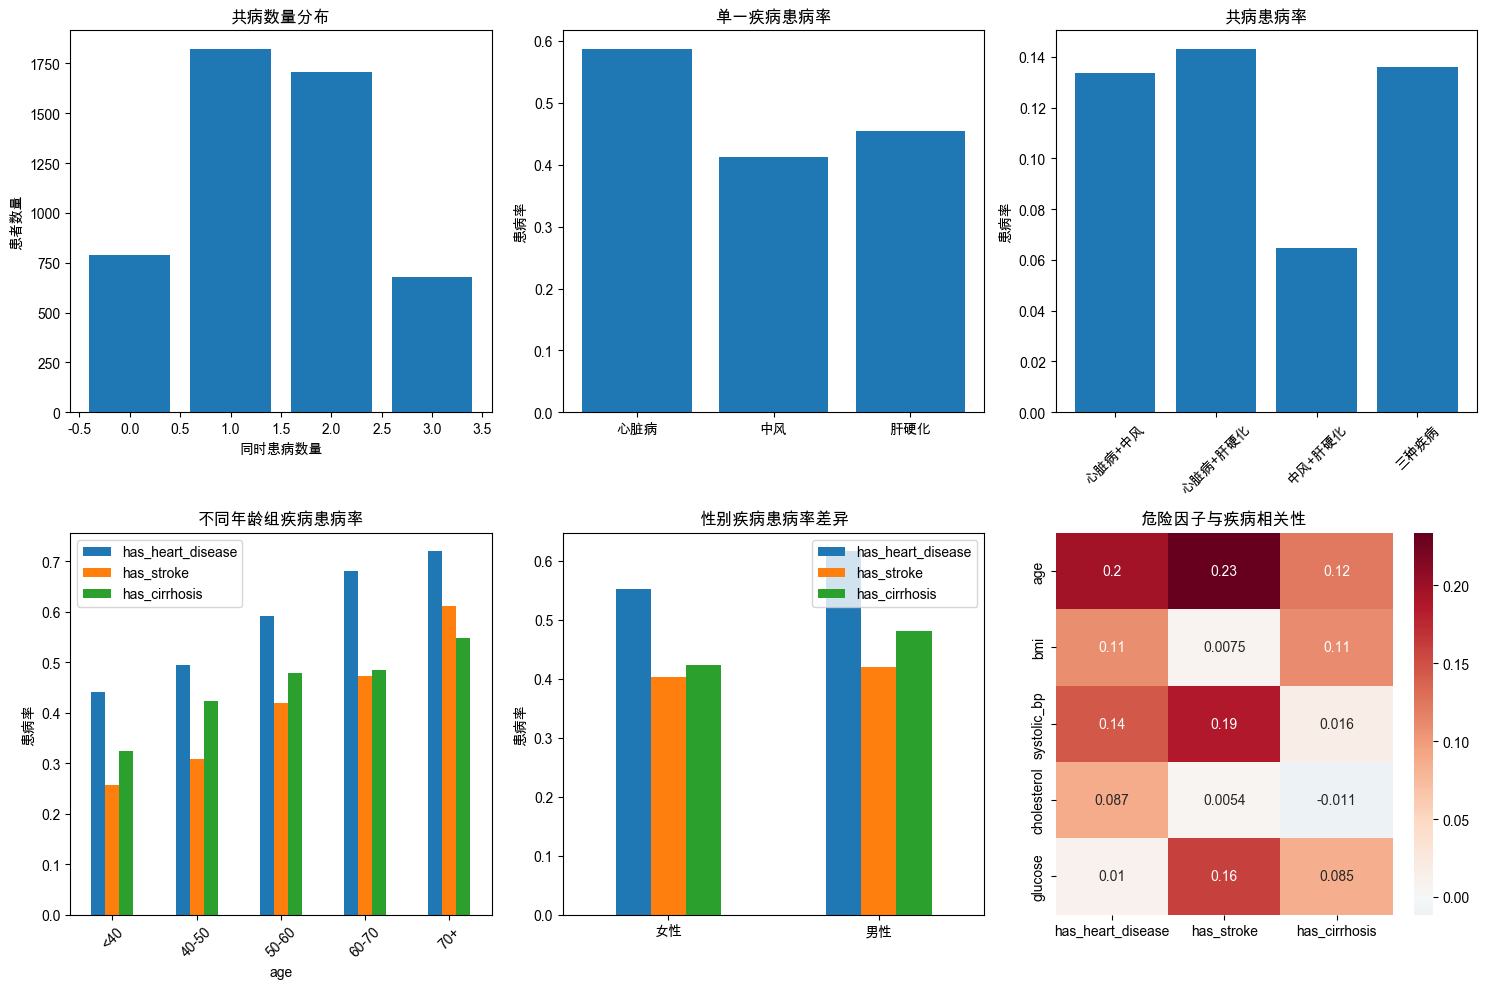

In [92]:
# 生成疾病标签（基于风险概率）
def generate_disease_labels(df):
    """基于计算的风险概率生成疾病标签"""
    np.random.seed(42)

    # 使用风险概率生成二进制标签
    df['has_heart_disease'] = np.random.binomial(1, df['heart_disease_risk'])
    df['has_stroke'] = np.random.binomial(1, df['stroke_risk'])
    df['has_cirrhosis'] = np.random.binomial(1, df['cirrhosis_risk'])

    # 计算共病情况
    df['comorbidity_count'] = df['has_heart_disease'] + df['has_stroke'] + df['has_cirrhosis']

    # 定义共病类别
    df['heart_stroke'] = (df['has_heart_disease'] == 1) & (df['has_stroke'] == 1) & (df['has_cirrhosis'] == 0)
    df['heart_cirrhosis'] = (df['has_heart_disease'] == 1) & (df['has_stroke'] == 0) & (df['has_cirrhosis'] == 1)
    df['stroke_cirrhosis'] = (df['has_heart_disease'] == 0) & (df['has_stroke'] == 1) & (df['has_cirrhosis'] == 1)
    df['all_three'] = (df['has_heart_disease'] == 1) & (df['has_stroke'] == 1) & (df['has_cirrhosis'] == 1)

    return df


df_comprehensive = generate_disease_labels(df_comprehensive)

# 年龄分组
age_groups = pd.cut(df_comprehensive['age'], bins=[0, 30, 50, 65, 100],
                    labels=['青年', '中年', '老年前期', '老年'])
df_comprehensive['age_group'] = age_groups

# 共病统计分析
print("\n=== 疾病患病率统计 ===")
print(f"心脏病患病率: {df_comprehensive['has_heart_disease'].mean():.3f}")
print(f"中风患病率: {df_comprehensive['has_stroke'].mean():.3f}")
print(f"肝硬化患病率: {df_comprehensive['has_cirrhosis'].mean():.3f}")

print("\n=== 共病情况统计 ===")
print(f"同时患心脏病和中风: {df_comprehensive['heart_stroke'].sum()} ({df_comprehensive['heart_stroke'].mean():.3f})")
print(
    f"同时患心脏病和肝硬化: {df_comprehensive['heart_cirrhosis'].sum()} ({df_comprehensive['heart_cirrhosis'].mean():.3f})")
print(
    f"同时患中风和肝硬化: {df_comprehensive['stroke_cirrhosis'].sum()} ({df_comprehensive['stroke_cirrhosis'].mean():.3f})")
print(f"同时患三种疾病: {df_comprehensive['all_three'].sum()} ({df_comprehensive['all_three'].mean():.3f})")

# 共病分布可视化
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
comorbidity_counts = df_comprehensive['comorbidity_count'].value_counts().sort_index()
plt.bar(comorbidity_counts.index, comorbidity_counts.values)
plt.title('共病数量分布')
plt.xlabel('同时患病数量')
plt.ylabel('患者数量')

plt.subplot(2, 3, 2)
disease_rates = [
    df_comprehensive['has_heart_disease'].mean(),
    df_comprehensive['has_stroke'].mean(),
    df_comprehensive['has_cirrhosis'].mean()
]
plt.bar(['心脏病', '中风', '肝硬化'], disease_rates)
plt.title('单一疾病患病率')
plt.ylabel('患病率')

plt.subplot(2, 3, 3)
comorbidity_rates = [
    df_comprehensive['heart_stroke'].mean(),
    df_comprehensive['heart_cirrhosis'].mean(),
    df_comprehensive['stroke_cirrhosis'].mean(),
    df_comprehensive['all_three'].mean()
]
plt.bar(['心脏病+中风', '心脏病+肝硬化', '中风+肝硬化', '三种疾病'], comorbidity_rates)
plt.title('共病患病率')
plt.ylabel('患病率')
plt.xticks(rotation=45)

# 年龄分组的疾病分布
plt.subplot(2, 3, 4)
age_groups = pd.cut(df_comprehensive['age'], bins=[0, 40, 50, 60, 70, 100],
                    labels=['<40', '40-50', '50-60', '60-70', '70+'])
age_disease = df_comprehensive.groupby(age_groups, observed=False)[
    ['has_heart_disease', 'has_stroke', 'has_cirrhosis']].mean()
age_disease.plot(kind='bar', ax=plt.gca())
plt.title('不同年龄组疾病患病率')
plt.ylabel('患病率')
plt.xticks(rotation=45)

# 性别差异分析
plt.subplot(2, 3, 5)
gender_disease = df_comprehensive.groupby('sex')[['has_heart_disease', 'has_stroke', 'has_cirrhosis']].mean()
gender_disease.index = ['女性', '男性']
gender_disease.plot(kind='bar', ax=plt.gca())
plt.title('性别疾病患病率差异')
plt.ylabel('患病率')
plt.xticks(rotation=0)

# 风险因子相关性热图
plt.subplot(2, 3, 6)
risk_factors = ['age', 'bmi', 'systolic_bp', 'cholesterol', 'glucose']
disease_outcomes = ['has_heart_disease', 'has_stroke', 'has_cirrhosis']
correlation_matrix = df_comprehensive[risk_factors + disease_outcomes].corr()
sns.heatmap(correlation_matrix.loc[risk_factors, disease_outcomes], annot=True, cmap='RdBu_r', center=0)
plt.title('危险因子与疾病相关性')

plt.tight_layout()
plt.savefig("comprehensive_disease_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

In [81]:
# 构建共病预测模型
def build_comorbidity_models(df):
    """构建预测共病的机器学习模型"""

    # 特征选择
    feature_cols = ['age', 'sex', 'bmi', 'systolic_bp', 'diastolic_bp', 'cholesterol',
                    'glucose', 'smoking', 'alcohol', 'family_history', 'exercise', 'stress_level']

    X = df[feature_cols]

    # 特征缩放
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=feature_cols)

    # 定义多个预测目标
    targets = {
        'heart_stroke': df['heart_stroke'].astype(int),
        'heart_cirrhosis': df['heart_cirrhosis'].astype(int),
        'stroke_cirrhosis': df['stroke_cirrhosis'].astype(int),
        'all_three': df['all_three'].astype(int)
    }

    models = {}
    results = {}

    for target_name, y in targets.items():
        print(f"\n=== {target_name} 预测模型 ===")

        # 划分训练测试集
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42, stratify=y
        )

        # 随机森林模型
        rf_model = RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            class_weight='balanced',
            max_depth=10
        )
        rf_model.fit(X_train, y_train)
        rf_pred = rf_model.predict(X_test)
        rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]

        # 逻辑回归模型
        lr_model = LogisticRegression(
            random_state=42,
            class_weight='balanced',
            max_iter=1000
        )
        lr_model.fit(X_train, y_train)
        lr_pred = lr_model.predict(X_test)
        lr_pred_proba = lr_model.predict_proba(X_test)[:, 1]

        # 模型评估
        rf_accuracy = accuracy_score(y_test, rf_pred)
        lr_accuracy = accuracy_score(y_test, lr_pred)

        try:
            rf_auc = roc_auc_score(y_test, rf_pred_proba)
            lr_auc = roc_auc_score(y_test, lr_pred_proba)
        except ValueError:
            rf_auc = lr_auc = 0.5  # 当只有一个类别时

        print(f"随机森林 - Accuracy: {rf_accuracy:.4f}, AUC: {rf_auc:.4f}")
        print(f"逻辑回归 - Accuracy: {lr_accuracy:.4f}, AUC: {lr_auc:.4f}")

        # 特征重要性分析
        feature_importance = pd.DataFrame({
            'Feature': feature_cols,
            'RF_Importance': rf_model.feature_importances_,
            'LR_Coefficient': np.abs(lr_model.coef_[0])
        }).sort_values(by='RF_Importance', ascending=False)

        print(f"Top 5 重要特征:")
        print(feature_importance.head())

        models[target_name] = {
            'rf_model': rf_model,
            'lr_model': lr_model,
            'scaler': scaler,
            'feature_cols': feature_cols
        }

        results[target_name] = {
            'rf_accuracy': rf_accuracy,
            'rf_auc': rf_auc,
            'lr_accuracy': lr_accuracy,
            'lr_auc': lr_auc,
            'feature_importance': feature_importance
        }

    return models, results


models, results = build_comorbidity_models(df_comprehensive)


=== heart_stroke 预测模型 ===
随机森林 - Accuracy: 0.8420, AUC: 0.6791
逻辑回归 - Accuracy: 0.6410, AUC: 0.6877
Top 5 重要特征:
       Feature  RF_Importance  LR_Coefficient
3  systolic_bp       0.168393        0.410764
0          age       0.165220        0.385382
2          bmi       0.114968        0.008613
5  cholesterol       0.114715        0.090904
6      glucose       0.111366        0.150628

=== heart_cirrhosis 预测模型 ===
随机森林 - Accuracy: 0.8050, AUC: 0.6023
逻辑回归 - Accuracy: 0.6080, AUC: 0.6361
Top 5 重要特征:
        Feature  RF_Importance  LR_Coefficient
2           bmi       0.163943        0.300800
0           age       0.125347        0.110596
4  diastolic_bp       0.122323        0.067495
3   systolic_bp       0.121366        0.037936
6       glucose       0.114414        0.062090

=== stroke_cirrhosis 预测模型 ===
随机森林 - Accuracy: 0.9350, AUC: 0.5834
逻辑回归 - Accuracy: 0.5940, AUC: 0.6057
Top 5 重要特征:
         Feature  RF_Importance  LR_Coefficient
6        glucose       0.151397        0.353736


In [82]:
# 综合风险评估函数
def comprehensive_risk_assessment(patient_data, models):
    """为单个患者计算所有疾病和共病风险"""

    # 确保输入数据格式正确
    if isinstance(patient_data, dict):
        patient_df = pd.DataFrame([patient_data])
    else:
        patient_df = patient_data.copy()

    # 特征缩放
    feature_cols = models['heart_stroke']['feature_cols']
    scaler = models['heart_stroke']['scaler']
    patient_scaled = scaler.transform(patient_df[feature_cols])
    patient_scaled = pd.DataFrame(patient_scaled, columns=feature_cols)

    # 预测各种共病概率
    risk_assessment = {}

    for condition, model_dict in models.items():
        rf_model = model_dict['rf_model']
        lr_model = model_dict['lr_model']

        rf_prob = rf_model.predict_proba(patient_scaled)[:, 1][0]
        lr_prob = lr_model.predict_proba(patient_scaled)[:, 1][0]

        # 使用两个模型的平均值作为最终预测
        avg_prob = (rf_prob + lr_prob) / 2

        risk_assessment[condition] = {
            'rf_probability': rf_prob,
            'lr_probability': lr_prob,
            'average_probability': avg_prob,
            'risk_level': 'High' if avg_prob > 0.3 else 'Medium' if avg_prob > 0.1 else 'Low'
        }

    return risk_assessment


# 示例患者风险评估
example_patients = [
    {
        'age': 65, 'sex': 1, 'bmi': 32, 'systolic_bp': 150, 'diastolic_bp': 95,
        'cholesterol': 240, 'glucose': 130, 'smoking': 1, 'alcohol': 2,
        'family_history': 1, 'exercise': 0, 'stress_level': 8
    },
    {
        'age': 45, 'sex': 0, 'bmi': 24, 'systolic_bp': 120, 'diastolic_bp': 80,
        'cholesterol': 180, 'glucose': 90, 'smoking': 0, 'alcohol': 0,
        'family_history': 0, 'exercise': 1, 'stress_level': 4
    }
]

print("\n=== 患者风险评估示例 ===")
for i, patient in enumerate(example_patients, 1):
    print(f"\n患者 {i} 特征:")
    for key, value in patient.items():
        print(f"  {key}: {value}")

    assessment = comprehensive_risk_assessment(patient, models)
    print(f"\n患者 {i} 共病风险评估:")
    for condition, risk in assessment.items():
        print(f"  {condition}: {risk['average_probability']:.3f} ({risk['risk_level']})")


=== 患者风险评估示例 ===

患者 1 特征:
  age: 65
  sex: 1
  bmi: 32
  systolic_bp: 150
  diastolic_bp: 95
  cholesterol: 240
  glucose: 130
  smoking: 1
  alcohol: 2
  family_history: 1
  exercise: 0
  stress_level: 8

患者 1 共病风险评估:
  heart_stroke: 0.628 (High)
  heart_cirrhosis: 0.503 (High)
  stroke_cirrhosis: 0.447 (High)
  all_three: 0.799 (High)

患者 2 特征:
  age: 45
  sex: 0
  bmi: 24
  systolic_bp: 120
  diastolic_bp: 80
  cholesterol: 180
  glucose: 90
  smoking: 0
  alcohol: 0
  family_history: 0
  exercise: 1
  stress_level: 4

患者 2 共病风险评估:
  heart_stroke: 0.160 (Medium)
  heart_cirrhosis: 0.211 (Medium)
  stroke_cirrhosis: 0.264 (Medium)
  all_three: 0.043 (Low)


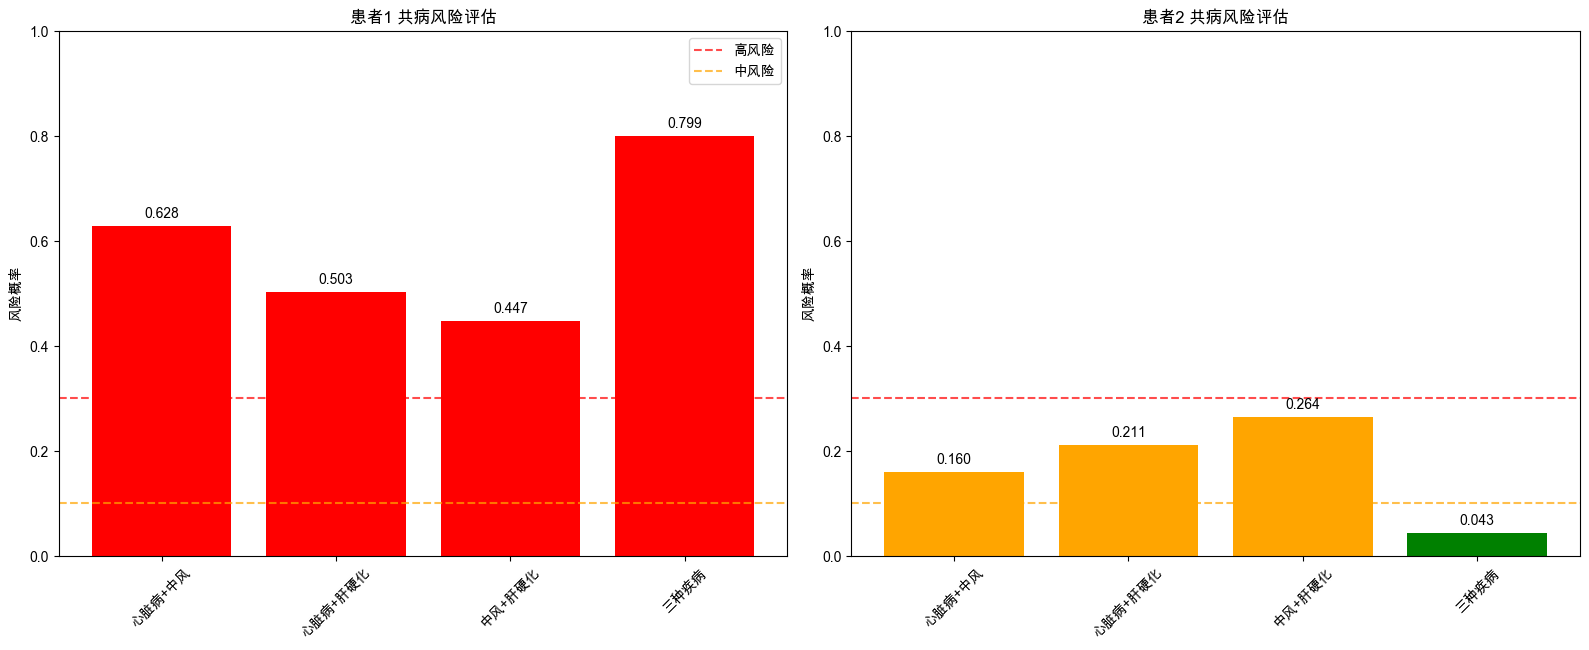

In [93]:
# 疾病风险可视化仪表板
def create_risk_dashboard(assessment_results):
    """创建风险评估可视化仪表板"""

    plt.figure(figsize=(16, 12))

    conditions = ['heart_stroke', 'heart_cirrhosis', 'stroke_cirrhosis', 'all_three']
    condition_labels = ['心脏病+中风', '心脏病+肝硬化', '中风+肝硬化', '三种疾病']

    for i, (patient_id, assessment) in enumerate(assessment_results.items()):
        plt.subplot(2, 2, i + 1)

        probabilities = [assessment[condition]['average_probability'] for condition in conditions]
        colors = ['red' if p > 0.3 else 'orange' if p > 0.1 else 'green' for p in probabilities]

        bars = plt.bar(condition_labels, probabilities, color=colors)
        plt.title(f'{patient_id} 共病风险评估')
        plt.ylabel('风险概率')
        plt.ylim(0, 1)
        plt.xticks(rotation=45)

        # 添加数值标签
        for bar, prob in zip(bars, probabilities):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                     f'{prob:.3f}', ha='center', va='bottom')

        # 添加风险等级线
        plt.axhline(y=0.3, color='red', linestyle='--', alpha=0.7, label='高风险')
        plt.axhline(y=0.1, color='orange', linestyle='--', alpha=0.7, label='中风险')

        if i == 0:
            plt.legend()

    plt.tight_layout()
    plt.savefig("comprehensive_risk_dashboard.png", dpi=300, bbox_inches='tight')
    plt.show()


# 为示例患者创建风险仪表板
assessment_results = {}
for i, patient in enumerate(example_patients, 1):
    assessment_results[f'患者{i}'] = comprehensive_risk_assessment(patient, models)

create_risk_dashboard(assessment_results)

### 完结，撒花！